In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment, save_ml_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

In [61]:
df = pd.read_csv('../processed_data/energy_production_with_engineered_features.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df = df[df['Station'] == 'Amberd1']

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [41]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [43]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.09916e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:16<00:00,  1.15s/it]


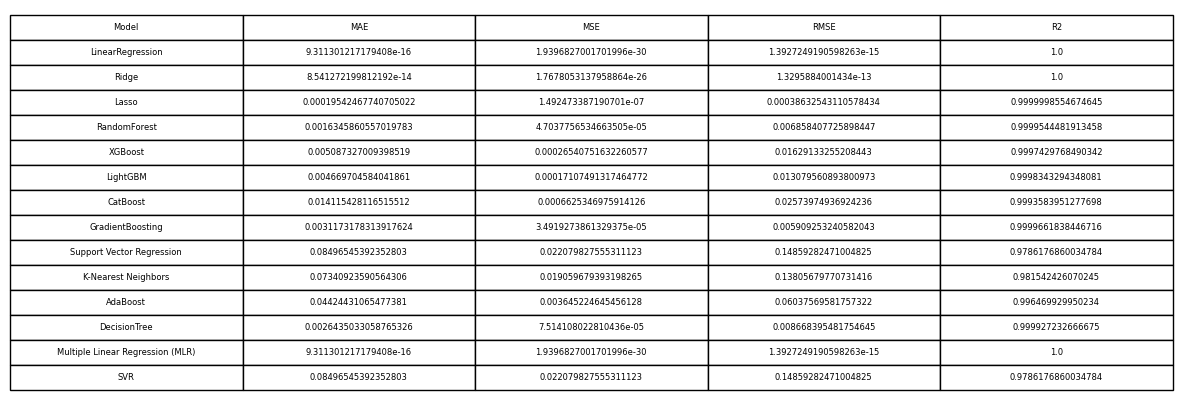

In [44]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

table_fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()
plt.close()

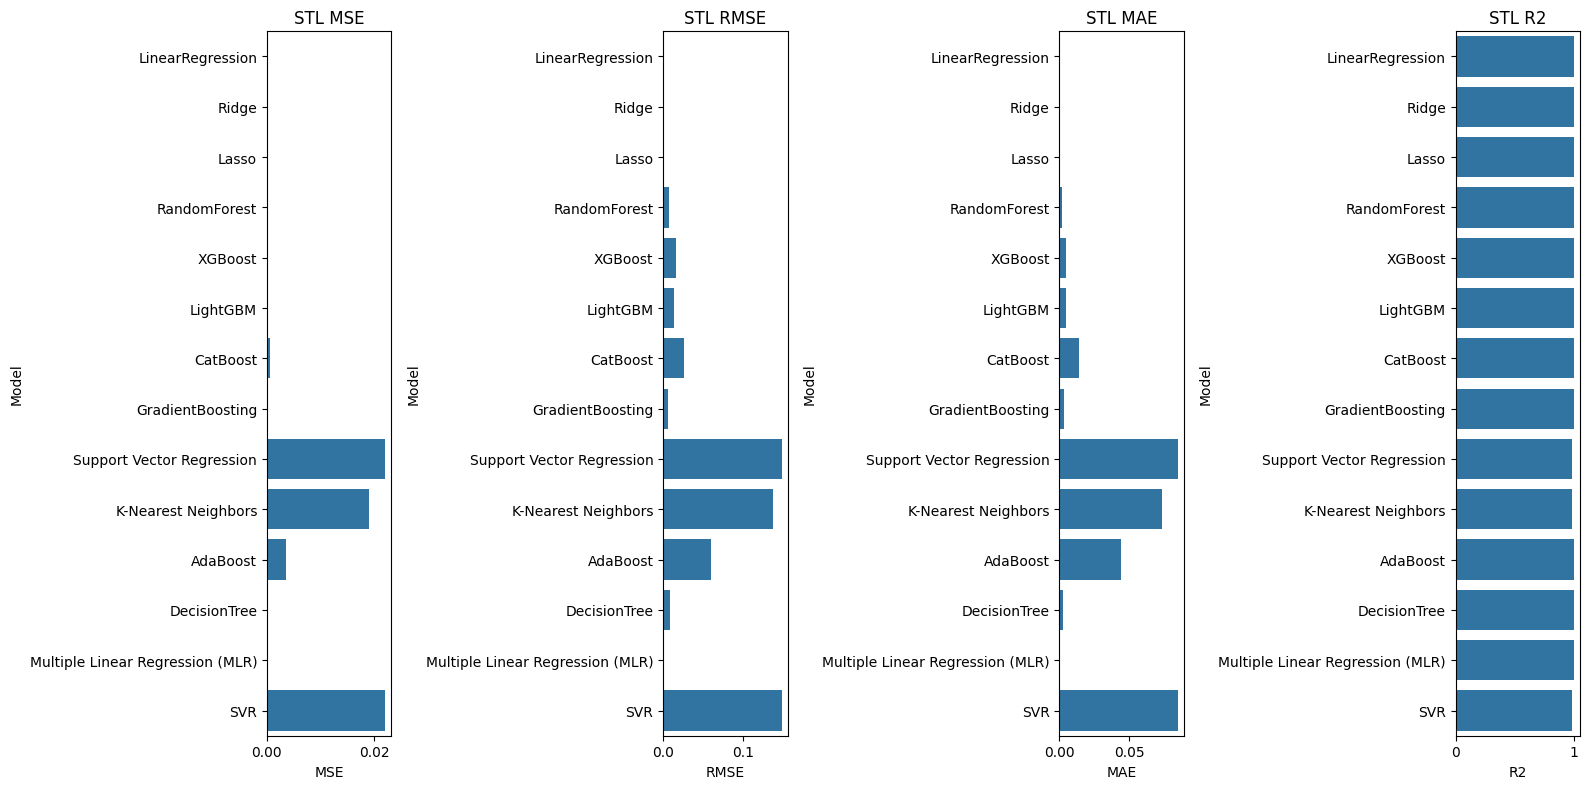

In [45]:
barplot_fig = plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()
plt.close()

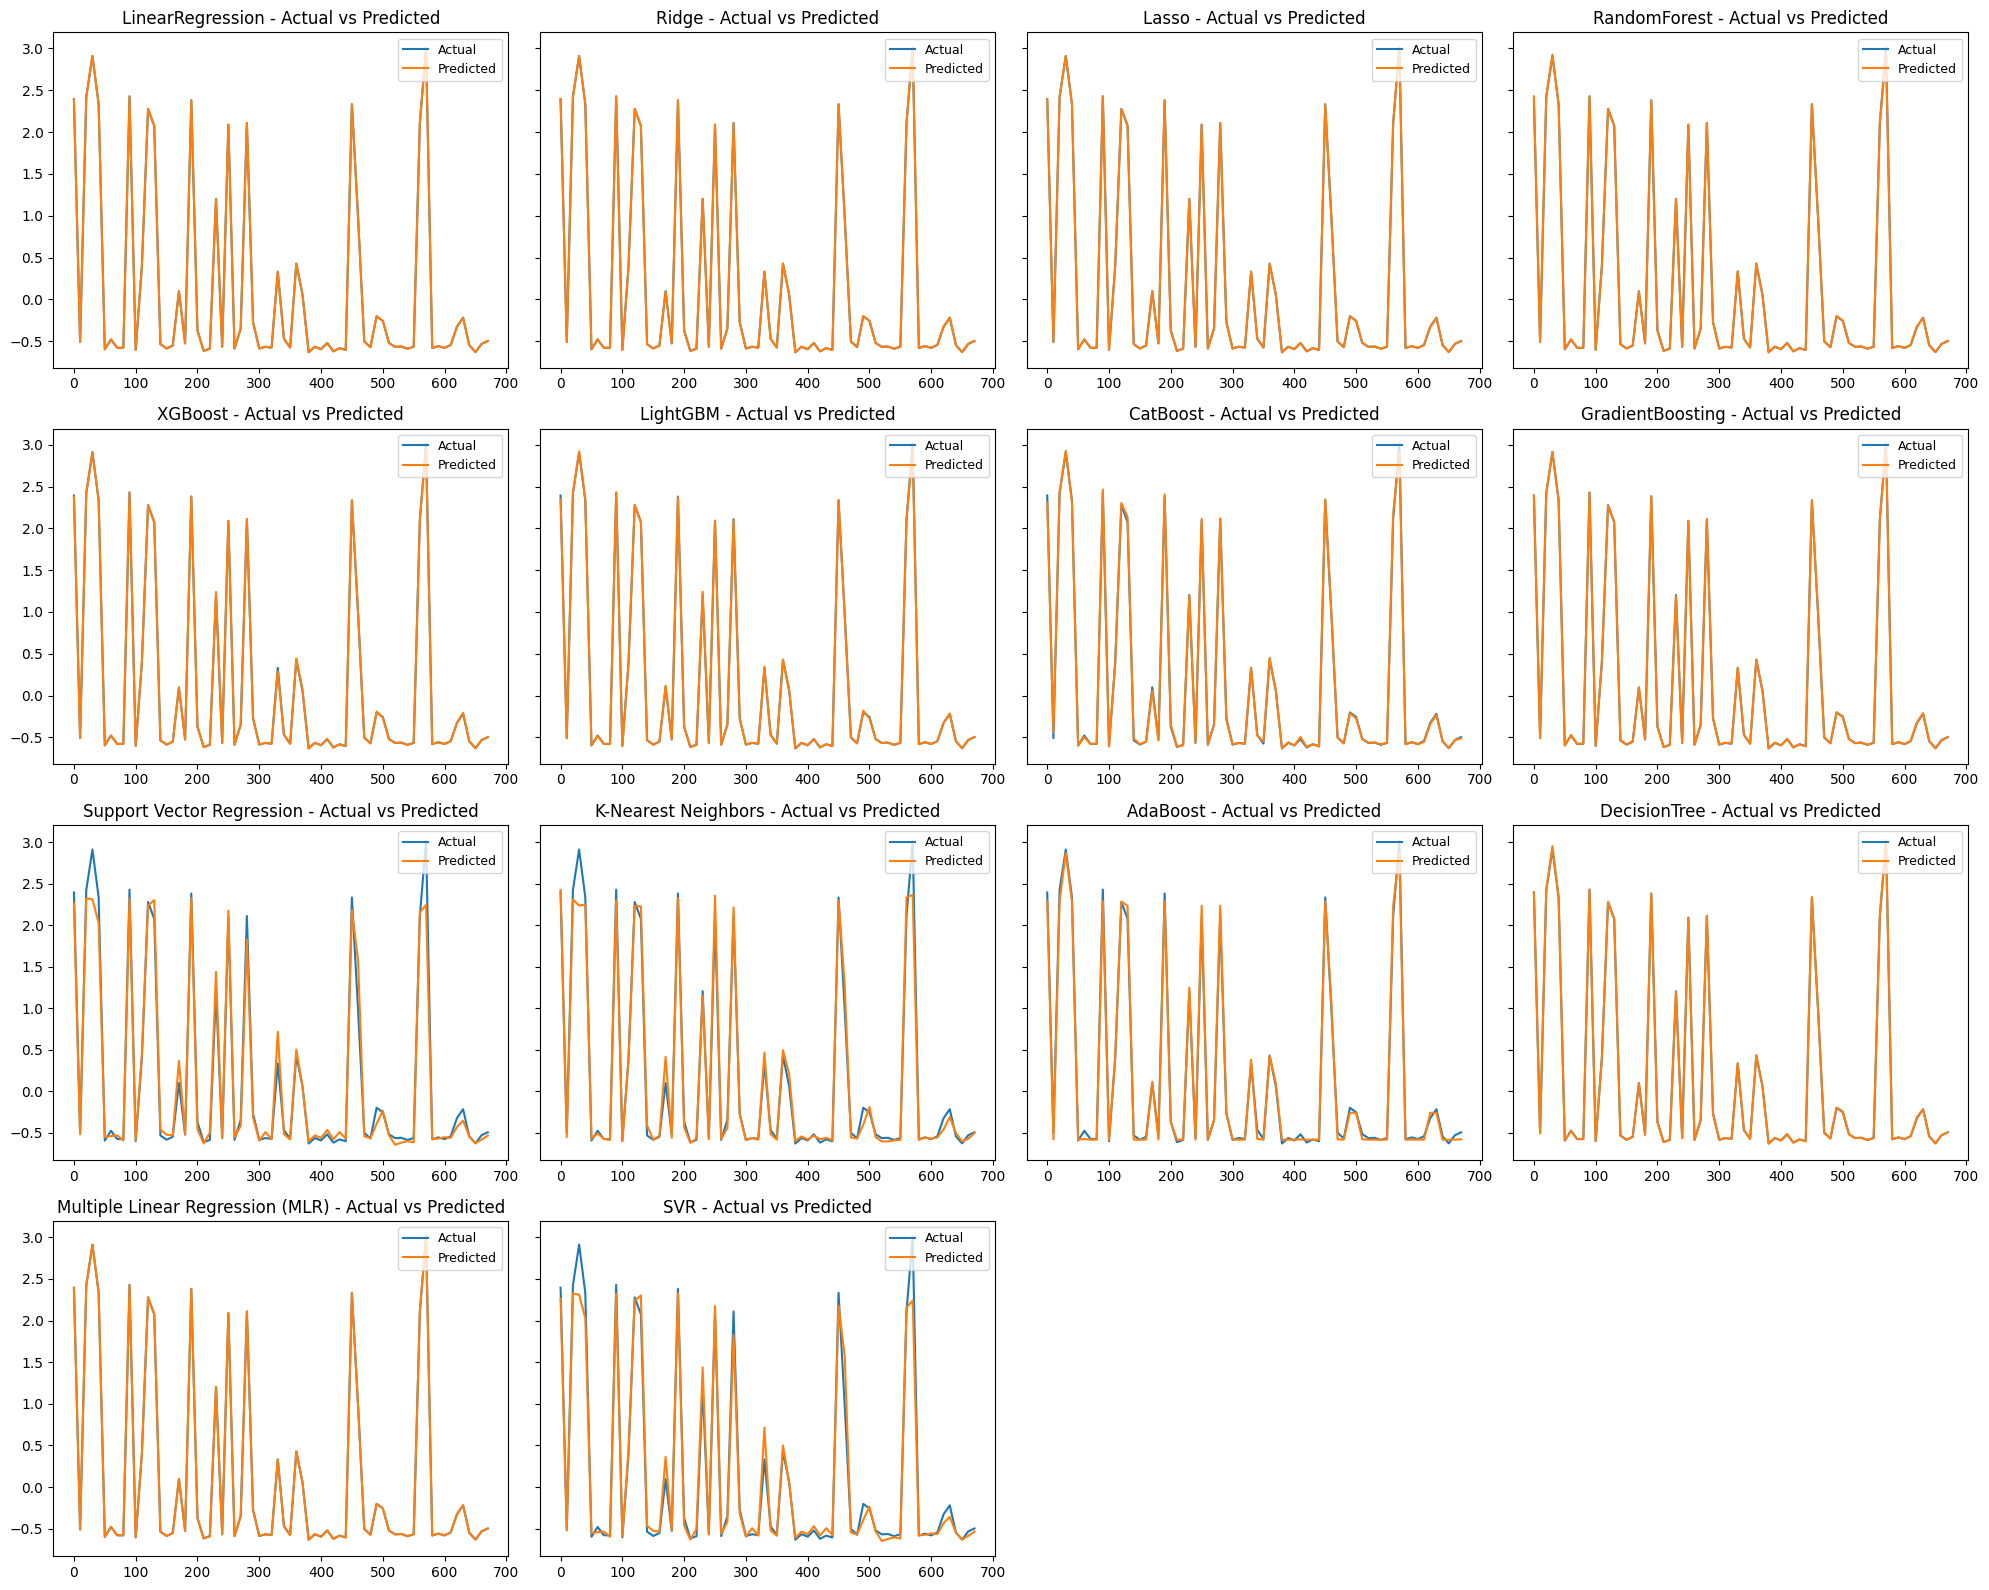

In [46]:
pred_figs = {}
cols_stl = 4
num_models_stl = len(results)
rows_stl = int(np.ceil(num_models_stl / cols_stl))
idx = np.arange(len(y_test))[::10]

fig, axes = plt.subplots(rows_stl, cols_stl, figsize=(20, 16), sharey='row')
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    ax = axes[i]
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend(fontsize=9, loc="upper right")

for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figs["AllModels"] = fig
plt.show()
plt.close()

In [10]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [11]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [12]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [14]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
    return history

In [15]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history

In [16]:
input_dim = X_test_tensor_tabular.shape[1]

nets = {
    "Net1":   Net1(input_dim),
    "Net2":   Net2(input_dim),
    "Net3":   Net3(input_dim),
    "Net4":   Net4(input_dim)
}

nets_tabular = {
    "Net1":    Net1(input_dim),
    "Net2":    Net2(input_dim),
    "Net3":    Net3(input_dim),
    "Net4":    Net4(input_dim),
    "FNN":     FNN(input_dim),
    "DeepFNN": DeepFNN(input_dim)
}

In [17]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

 10%|██████████▏                                                                                           | 10/100 [00:00<00:01, 47.25it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.1221, RMSE: 0.3495, MAE: 0.2236, R2: 0.8768
Test:  MSE: 0.1231, RMSE: 0.3508, MAE: 0.2263, R2: 0.8808

Model: Net1 | Epoch: 10/100
Train: MSE: 0.0016, RMSE: 0.0403, MAE: 0.0292, R2: 0.9984
Test:  MSE: 0.0016, RMSE: 0.0398, MAE: 0.0282, R2: 0.9985


 25%|█████████████████████████▌                                                                            | 25/100 [00:00<00:01, 44.11it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0005, RMSE: 0.0225, MAE: 0.0163, R2: 0.9995
Test:  MSE: 0.0005, RMSE: 0.0232, MAE: 0.0168, R2: 0.9995


 36%|████████████████████████████████████▋                                                                 | 36/100 [00:00<00:01, 47.32it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0003, RMSE: 0.0171, MAE: 0.0122, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0186, MAE: 0.0136, R2: 0.9997


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [00:00<00:01, 46.62it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0002, RMSE: 0.0142, MAE: 0.0101, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0163, MAE: 0.0117, R2: 0.9997


 57%|██████████████████████████████████████████████████████████▏                                           | 57/100 [00:01<00:00, 47.80it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0126, MAE: 0.0090, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0153, MAE: 0.0104, R2: 0.9998


 68%|█████████████████████████████████████████████████████████████████████▎                                | 68/100 [00:01<00:00, 49.22it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0113, MAE: 0.0080, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0143, MAE: 0.0096, R2: 0.9998

Model: Net1 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0104, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0136, MAE: 0.0091, R2: 0.9998


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:01<00:00, 43.41it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0098, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0134, MAE: 0.0089, R2: 0.9998


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:02<00:00, 42.97it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0123, MAE: 0.0083, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.08it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0091, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0123, MAE: 0.0085, R2: 0.9999


  4%|████                                                                                                   | 4/100 [00:00<00:03, 31.17it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0142, RMSE: 0.1190, MAE: 0.0862, R2: 0.9857
Test:  MSE: 0.0143, RMSE: 0.1196, MAE: 0.0855, R2: 0.9862


 14%|██████████████▎                                                                                       | 14/100 [00:00<00:03, 26.59it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0004, RMSE: 0.0196, MAE: 0.0142, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0214, MAE: 0.0157, R2: 0.9996


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 28.05it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0128, MAE: 0.0092, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0155, MAE: 0.0112, R2: 0.9998


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 28.84it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0106, MAE: 0.0080, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0138, MAE: 0.0103, R2: 0.9998


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:02, 22.90it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0082, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0123, MAE: 0.0086, R2: 0.9999


 53%|██████████████████████████████████████████████████████                                                | 53/100 [00:01<00:01, 25.20it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0075, MAE: 0.0055, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0079, R2: 0.9999


 65%|██████████████████████████████████████████████████████████████████▎                                   | 65/100 [00:02<00:01, 29.00it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0107, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0134, MAE: 0.0099, R2: 0.9998


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 27.41it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0079, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0112, MAE: 0.0080, R2: 0.9999


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:03<00:00, 25.88it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0060, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0114, MAE: 0.0081, R2: 0.9999


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 95/100 [00:03<00:00, 26.66it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0053, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0103, MAE: 0.0075, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.08it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0056, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0107, MAE: 0.0075, R2: 0.9999


  2%|██                                                                                                     | 2/100 [00:00<00:05, 19.16it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0094, RMSE: 0.0968, MAE: 0.0748, R2: 0.9906
Test:  MSE: 0.0095, RMSE: 0.0975, MAE: 0.0772, R2: 0.9908


 13%|█████████████▎                                                                                        | 13/100 [00:00<00:04, 18.87it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0002, RMSE: 0.0158, MAE: 0.0128, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0178, MAE: 0.0141, R2: 0.9997


 23%|███████████████████████▍                                                                              | 23/100 [00:01<00:04, 17.56it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0090, MAE: 0.0067, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0122, MAE: 0.0086, R2: 0.9999


 32%|████████████████████████████████▋                                                                     | 32/100 [00:01<00:03, 18.79it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0086, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0117, MAE: 0.0088, R2: 0.9999


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 18.41it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0080, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0108, MAE: 0.0078, R2: 0.9999


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:02<00:02, 17.29it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0000, RMSE: 0.0061, MAE: 0.0048, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0090, MAE: 0.0064, R2: 0.9999


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:03<00:02, 18.95it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0143, MAE: 0.0107, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0152, MAE: 0.0116, R2: 0.9998


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [00:03<00:01, 17.99it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0090, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0108, MAE: 0.0079, R2: 0.9999


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:04<00:00, 18.62it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0088, MAE: 0.0066, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0104, MAE: 0.0076, R2: 0.9999


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:05<00:00, 18.25it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0113, MAE: 0.0079, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0125, MAE: 0.0086, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.24it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0059, MAE: 0.0048, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0083, MAE: 0.0062, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:24,  4.12it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0156, RMSE: 0.1248, MAE: 0.0907, R2: 0.9843
Test:  MSE: 0.0168, RMSE: 0.1295, MAE: 0.0935, R2: 0.9838


 10%|██████████▏                                                                                           | 10/100 [00:02<00:20,  4.29it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0037, RMSE: 0.0607, MAE: 0.0438, R2: 0.9963
Test:  MSE: 0.0041, RMSE: 0.0643, MAE: 0.0457, R2: 0.9960


 20%|████████████████████▍                                                                                 | 20/100 [00:04<00:18,  4.25it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0080, RMSE: 0.0896, MAE: 0.0537, R2: 0.9919
Test:  MSE: 0.0084, RMSE: 0.0914, MAE: 0.0558, R2: 0.9919


 30%|██████████████████████████████▌                                                                       | 30/100 [00:07<00:16,  4.35it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0073, RMSE: 0.0855, MAE: 0.0755, R2: 0.9926
Test:  MSE: 0.0071, RMSE: 0.0845, MAE: 0.0732, R2: 0.9931


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:09<00:14,  4.26it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0069, RMSE: 0.0830, MAE: 0.0727, R2: 0.9931
Test:  MSE: 0.0068, RMSE: 0.0825, MAE: 0.0721, R2: 0.9934


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:11<00:12,  4.10it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0028, RMSE: 0.0530, MAE: 0.0427, R2: 0.9972
Test:  MSE: 0.0027, RMSE: 0.0524, MAE: 0.0422, R2: 0.9973


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:14<00:10,  3.98it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0040, RMSE: 0.0631, MAE: 0.0488, R2: 0.9960
Test:  MSE: 0.0039, RMSE: 0.0623, MAE: 0.0485, R2: 0.9962


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:16<00:07,  4.04it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0064, RMSE: 0.0799, MAE: 0.0499, R2: 0.9936
Test:  MSE: 0.0064, RMSE: 0.0797, MAE: 0.0507, R2: 0.9938


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:19<00:04,  4.24it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0065, RMSE: 0.0807, MAE: 0.0628, R2: 0.9934
Test:  MSE: 0.0063, RMSE: 0.0791, MAE: 0.0616, R2: 0.9939


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:21<00:02,  4.62it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0065, RMSE: 0.0808, MAE: 0.0476, R2: 0.9934
Test:  MSE: 0.0066, RMSE: 0.0815, MAE: 0.0491, R2: 0.9936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


Model: Net4 | Epoch: 100/100
Train: MSE: 0.0112, RMSE: 0.1057, MAE: 0.0618, R2: 0.9887
Test:  MSE: 0.0115, RMSE: 0.1074, MAE: 0.0647, R2: 0.9888


In [18]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

  9%|█████████▎                                                                                             | 9/100 [00:00<00:02, 40.72it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.5856, RMSE: 0.7653, MAE: 0.5426, R2: 0.4094
Test:  MSE: 0.6154, RMSE: 0.7845, MAE: 0.5579, R2: 0.4041


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:01, 46.02it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0085, RMSE: 0.0925, MAE: 0.0653, R2: 0.9914
Test:  MSE: 0.0079, RMSE: 0.0890, MAE: 0.0639, R2: 0.9923


 26%|██████████████████████████▌                                                                           | 26/100 [00:00<00:01, 45.51it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0021, RMSE: 0.0458, MAE: 0.0319, R2: 0.9979
Test:  MSE: 0.0019, RMSE: 0.0440, MAE: 0.0317, R2: 0.9981

Model: Net1 | Epoch: 30/100
Train: MSE: 0.0012, RMSE: 0.0350, MAE: 0.0248, R2: 0.9988
Test:  MSE: 0.0012, RMSE: 0.0349, MAE: 0.0255, R2: 0.9988


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:00<00:01, 48.23it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0009, RMSE: 0.0301, MAE: 0.0213, R2: 0.9991
Test:  MSE: 0.0009, RMSE: 0.0303, MAE: 0.0225, R2: 0.9991


 57%|██████████████████████████████████████████████████████████▏                                           | 57/100 [00:01<00:00, 53.84it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0007, RMSE: 0.0270, MAE: 0.0191, R2: 0.9993
Test:  MSE: 0.0008, RMSE: 0.0275, MAE: 0.0204, R2: 0.9993

Model: Net1 | Epoch: 60/100
Train: MSE: 0.0006, RMSE: 0.0247, MAE: 0.0175, R2: 0.9994
Test:  MSE: 0.0007, RMSE: 0.0257, MAE: 0.0190, R2: 0.9994


 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 78/100 [00:01<00:00, 59.26it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0005, RMSE: 0.0230, MAE: 0.0164, R2: 0.9995
Test:  MSE: 0.0006, RMSE: 0.0244, MAE: 0.0182, R2: 0.9994


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:01<00:00, 42.09it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0005, RMSE: 0.0214, MAE: 0.0153, R2: 0.9995
Test:  MSE: 0.0005, RMSE: 0.0233, MAE: 0.0173, R2: 0.9995

Model: Net1 | Epoch: 90/100
Train: MSE: 0.0004, RMSE: 0.0203, MAE: 0.0146, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0225, MAE: 0.0168, R2: 0.9995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.17it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0004, RMSE: 0.0196, MAE: 0.0140, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0219, MAE: 0.0161, R2: 0.9995


  4%|████                                                                                                   | 4/100 [00:00<00:02, 35.85it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.2443, RMSE: 0.4943, MAE: 0.3018, R2: 0.7536
Test:  MSE: 0.2559, RMSE: 0.5058, MAE: 0.3094, R2: 0.7522


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:03, 23.28it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0019, RMSE: 0.0438, MAE: 0.0304, R2: 0.9981
Test:  MSE: 0.0023, RMSE: 0.0478, MAE: 0.0329, R2: 0.9978


 25%|█████████████████████████▌                                                                            | 25/100 [00:01<00:03, 22.41it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0006, RMSE: 0.0252, MAE: 0.0181, R2: 0.9994
Test:  MSE: 0.0008, RMSE: 0.0285, MAE: 0.0202, R2: 0.9992


 32%|████████████████████████████████▋                                                                     | 32/100 [00:01<00:02, 24.38it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0004, RMSE: 0.0196, MAE: 0.0144, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0228, MAE: 0.0164, R2: 0.9995


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:01<00:02, 21.69it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0003, RMSE: 0.0162, MAE: 0.0119, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0195, MAE: 0.0140, R2: 0.9996


 49%|█████████████████████████████████████████████████▉                                                    | 49/100 [00:02<00:01, 25.64it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0142, MAE: 0.0104, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0175, MAE: 0.0126, R2: 0.9997


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:02<00:01, 20.16it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0126, MAE: 0.0092, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0158, MAE: 0.0112, R2: 0.9998


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:03<00:01, 18.43it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0112, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0145, MAE: 0.0103, R2: 0.9998


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:04<00:00, 17.93it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0104, MAE: 0.0076, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0098, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:04<00:00, 18.10it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0101, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0134, MAE: 0.0095, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.98it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0090, MAE: 0.0066, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0127, MAE: 0.0090, R2: 0.9998


  3%|███                                                                                                    | 3/100 [00:00<00:04, 23.67it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.2551, RMSE: 0.5051, MAE: 0.3036, R2: 0.7428
Test:  MSE: 0.2720, RMSE: 0.5216, MAE: 0.3147, R2: 0.7366


 10%|██████████▏                                                                                           | 10/100 [00:02<00:24,  3.62it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0009, RMSE: 0.0308, MAE: 0.0224, R2: 0.9990
Test:  MSE: 0.0011, RMSE: 0.0338, MAE: 0.0242, R2: 0.9989


 19%|███████████████████▍                                                                                  | 19/100 [00:02<00:08,  9.86it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0004, RMSE: 0.0188, MAE: 0.0137, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0218, MAE: 0.0150, R2: 0.9995


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:03<00:04, 16.07it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0002, RMSE: 0.0145, MAE: 0.0105, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0180, MAE: 0.0120, R2: 0.9997


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:04, 13.31it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0117, MAE: 0.0088, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0158, MAE: 0.0109, R2: 0.9998


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:06<00:08,  5.77it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0095, MAE: 0.0072, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0143, MAE: 0.0097, R2: 0.9998


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:07<00:02, 13.77it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0081, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0132, MAE: 0.0086, R2: 0.9998


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:07<00:01, 20.78it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0087, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0089, R2: 0.9998


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:08<00:00, 17.16it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0064, MAE: 0.0048, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0119, MAE: 0.0075, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:08<00:00, 21.35it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0060, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0114, MAE: 0.0072, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.25it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0058, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0114, MAE: 0.0072, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:12,  7.73it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0354, RMSE: 0.1881, MAE: 0.1702, R2: 0.9643
Test:  MSE: 0.0326, RMSE: 0.1805, MAE: 0.1644, R2: 0.9685


 11%|███████████▏                                                                                          | 11/100 [00:01<00:14,  5.96it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0042, RMSE: 0.0649, MAE: 0.0483, R2: 0.9957
Test:  MSE: 0.0045, RMSE: 0.0669, MAE: 0.0495, R2: 0.9957


 20%|████████████████████▍                                                                                 | 20/100 [00:03<00:12,  6.44it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0025, RMSE: 0.0503, MAE: 0.0374, R2: 0.9974
Test:  MSE: 0.0029, RMSE: 0.0535, MAE: 0.0393, R2: 0.9972


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:10,  6.40it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0049, RMSE: 0.0697, MAE: 0.0602, R2: 0.9951
Test:  MSE: 0.0049, RMSE: 0.0699, MAE: 0.0593, R2: 0.9953


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:06<00:13,  4.25it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0028, RMSE: 0.0532, MAE: 0.0438, R2: 0.9971
Test:  MSE: 0.0029, RMSE: 0.0535, MAE: 0.0436, R2: 0.9972


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:08<00:08,  5.46it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0087, RMSE: 0.0932, MAE: 0.0550, R2: 0.9912
Test:  MSE: 0.0093, RMSE: 0.0962, MAE: 0.0572, R2: 0.9910


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:10<00:05,  7.42it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0033, RMSE: 0.0576, MAE: 0.0387, R2: 0.9967
Test:  MSE: 0.0033, RMSE: 0.0578, MAE: 0.0397, R2: 0.9968


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:13<00:11,  2.59it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0032, RMSE: 0.0563, MAE: 0.0416, R2: 0.9968
Test:  MSE: 0.0032, RMSE: 0.0562, MAE: 0.0407, R2: 0.9969


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:15<00:03,  5.88it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0138, RMSE: 0.1175, MAE: 0.0672, R2: 0.9861
Test:  MSE: 0.0142, RMSE: 0.1193, MAE: 0.0692, R2: 0.9862


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:16<00:01,  6.31it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0058, RMSE: 0.0760, MAE: 0.0457, R2: 0.9942
Test:  MSE: 0.0060, RMSE: 0.0775, MAE: 0.0475, R2: 0.9942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]



Model: Net4 | Epoch: 100/100
Train: MSE: 0.0075, RMSE: 0.0869, MAE: 0.0537, R2: 0.9924
Test:  MSE: 0.0078, RMSE: 0.0881, MAE: 0.0561, R2: 0.9925


  1%|█                                                                                                      | 1/100 [00:00<00:22,  4.50it/s]


Model: FNN | Epoch: 1/100
Train: MSE: 0.5233, RMSE: 0.7234, MAE: 0.6120, R2: 0.4723
Test:  MSE: 0.5336, RMSE: 0.7305, MAE: 0.6142, R2: 0.4832


 13%|█████████████▎                                                                                        | 13/100 [00:01<00:06, 13.72it/s]


Model: FNN | Epoch: 10/100
Train: MSE: 0.0114, RMSE: 0.1068, MAE: 0.0843, R2: 0.9885
Test:  MSE: 0.0114, RMSE: 0.1067, MAE: 0.0826, R2: 0.9890


 27%|███████████████████████████▌                                                                          | 27/100 [00:01<00:02, 27.70it/s]


Model: FNN | Epoch: 20/100
Train: MSE: 0.0068, RMSE: 0.0824, MAE: 0.0627, R2: 0.9932
Test:  MSE: 0.0072, RMSE: 0.0847, MAE: 0.0640, R2: 0.9931


 35%|███████████████████████████████████▋                                                                  | 35/100 [00:02<00:02, 30.82it/s]


Model: FNN | Epoch: 30/100
Train: MSE: 0.0064, RMSE: 0.0801, MAE: 0.0582, R2: 0.9935
Test:  MSE: 0.0072, RMSE: 0.0847, MAE: 0.0616, R2: 0.9930


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:02, 27.32it/s]


Model: FNN | Epoch: 40/100
Train: MSE: 0.0048, RMSE: 0.0693, MAE: 0.0509, R2: 0.9952
Test:  MSE: 0.0053, RMSE: 0.0730, MAE: 0.0533, R2: 0.9948


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:03<00:03, 14.14it/s]


Model: FNN | Epoch: 50/100
Train: MSE: 0.0066, RMSE: 0.0810, MAE: 0.0596, R2: 0.9934
Test:  MSE: 0.0074, RMSE: 0.0859, MAE: 0.0632, R2: 0.9929


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:04<00:02, 14.32it/s]


Model: FNN | Epoch: 60/100
Train: MSE: 0.0101, RMSE: 0.1003, MAE: 0.0641, R2: 0.9899
Test:  MSE: 0.0115, RMSE: 0.1070, MAE: 0.0695, R2: 0.9889


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:05<00:03,  8.11it/s]


Model: FNN | Epoch: 70/100
Train: MSE: 0.0034, RMSE: 0.0579, MAE: 0.0418, R2: 0.9966
Test:  MSE: 0.0041, RMSE: 0.0640, MAE: 0.0461, R2: 0.9960


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:06<00:03,  5.12it/s]


Model: FNN | Epoch: 80/100
Train: MSE: 0.0037, RMSE: 0.0607, MAE: 0.0427, R2: 0.9963
Test:  MSE: 0.0044, RMSE: 0.0664, MAE: 0.0466, R2: 0.9957


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:08<00:01,  7.25it/s]


Model: FNN | Epoch: 90/100
Train: MSE: 0.0037, RMSE: 0.0611, MAE: 0.0459, R2: 0.9962
Test:  MSE: 0.0043, RMSE: 0.0659, MAE: 0.0492, R2: 0.9958


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.60it/s]



Model: FNN | Epoch: 100/100
Train: MSE: 0.0034, RMSE: 0.0580, MAE: 0.0431, R2: 0.9966
Test:  MSE: 0.0037, RMSE: 0.0609, MAE: 0.0442, R2: 0.9964


  2%|██                                                                                                     | 2/100 [00:00<00:05, 17.83it/s]


Model: DeepFNN | Epoch: 1/100
Train: MSE: 0.5177, RMSE: 0.7195, MAE: 0.5254, R2: 0.4779
Test:  MSE: 0.5428, RMSE: 0.7367, MAE: 0.5312, R2: 0.4744


 11%|███████████▏                                                                                          | 11/100 [00:00<00:05, 15.62it/s]


Model: DeepFNN | Epoch: 10/100
Train: MSE: 0.0073, RMSE: 0.0852, MAE: 0.0667, R2: 0.9927
Test:  MSE: 0.0074, RMSE: 0.0858, MAE: 0.0674, R2: 0.9929


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:03, 20.72it/s]


Model: DeepFNN | Epoch: 20/100
Train: MSE: 0.0044, RMSE: 0.0662, MAE: 0.0526, R2: 0.9956
Test:  MSE: 0.0047, RMSE: 0.0684, MAE: 0.0532, R2: 0.9955


 34%|██████████████████████████████████▋                                                                   | 34/100 [00:01<00:02, 23.34it/s]


Model: DeepFNN | Epoch: 30/100
Train: MSE: 0.0075, RMSE: 0.0863, MAE: 0.0579, R2: 0.9925
Test:  MSE: 0.0079, RMSE: 0.0891, MAE: 0.0596, R2: 0.9923


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:02<00:02, 22.04it/s]


Model: DeepFNN | Epoch: 40/100
Train: MSE: 0.0083, RMSE: 0.0913, MAE: 0.0654, R2: 0.9916
Test:  MSE: 0.0088, RMSE: 0.0936, MAE: 0.0672, R2: 0.9915


 53%|██████████████████████████████████████████████████████                                                | 53/100 [00:02<00:01, 24.76it/s]


Model: DeepFNN | Epoch: 50/100
Train: MSE: 0.0058, RMSE: 0.0762, MAE: 0.0557, R2: 0.9941
Test:  MSE: 0.0061, RMSE: 0.0779, MAE: 0.0565, R2: 0.9941


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:02<00:01, 23.26it/s]


Model: DeepFNN | Epoch: 60/100
Train: MSE: 0.0053, RMSE: 0.0725, MAE: 0.0571, R2: 0.9947
Test:  MSE: 0.0052, RMSE: 0.0721, MAE: 0.0559, R2: 0.9950


 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 76/100 [00:03<00:00, 26.25it/s]


Model: DeepFNN | Epoch: 70/100
Train: MSE: 0.0043, RMSE: 0.0654, MAE: 0.0483, R2: 0.9957
Test:  MSE: 0.0044, RMSE: 0.0660, MAE: 0.0476, R2: 0.9958


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 29.72it/s]


Model: DeepFNN | Epoch: 80/100
Train: MSE: 0.0049, RMSE: 0.0703, MAE: 0.0468, R2: 0.9950
Test:  MSE: 0.0053, RMSE: 0.0726, MAE: 0.0476, R2: 0.9949


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:04<00:00, 29.67it/s]


Model: DeepFNN | Epoch: 90/100
Train: MSE: 0.0039, RMSE: 0.0624, MAE: 0.0466, R2: 0.9961
Test:  MSE: 0.0041, RMSE: 0.0637, MAE: 0.0467, R2: 0.9961


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.39it/s]


Model: DeepFNN | Epoch: 100/100
Train: MSE: 0.0035, RMSE: 0.0589, MAE: 0.0412, R2: 0.9965
Test:  MSE: 0.0036, RMSE: 0.0601, MAE: 0.0413, R2: 0.9965


In [19]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [20]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1     98   0.000075  0.000141    0.008661   0.011884   0.006496   
1  Net2     99   0.000032  0.000088    0.005662   0.009359   0.003978   
2  Net3     99   0.000021  0.000054    0.004552   0.007333   0.003468   
3  Net4     39   0.001371  0.001523    0.037028   0.039022   0.027714   

   Test MAE  Train R2   Test R2  
0  0.008026  0.999924  0.999863  
1  0.006273  0.999968  0.999915  
2  0.005116  0.999979  0.999948  
3  0.028564  0.998617  0.998525

In [21]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     86   0.001743  0.001864    0.041753   0.043170   0.031345   
1      FNN     83   0.002942  0.003427    0.054237   0.058539   0.038593   
2     Net1     99   0.000373  0.000476    0.019312   0.021819   0.013896   
3     Net2     99   0.000080  0.000160    0.008951   0.012630   0.006562   
4     Net3     95   0.000032  0.000124    0.005657   0.011153   0.004317   
5     Net4     29   0.001870  0.001928    0.043247   0.043914   0.033810   

   Test MAE  Train R2   Test R2  
0  0.031412  0.998242  0.998195  
1  0.041295  0.997034  0.996681  
2  0.016225  0.999624  0.999539  
3  0.008722  0.999919  0.999846  
4  0.007114  0.999968  0.999880  
5  0.033233  0.998114  0.998132

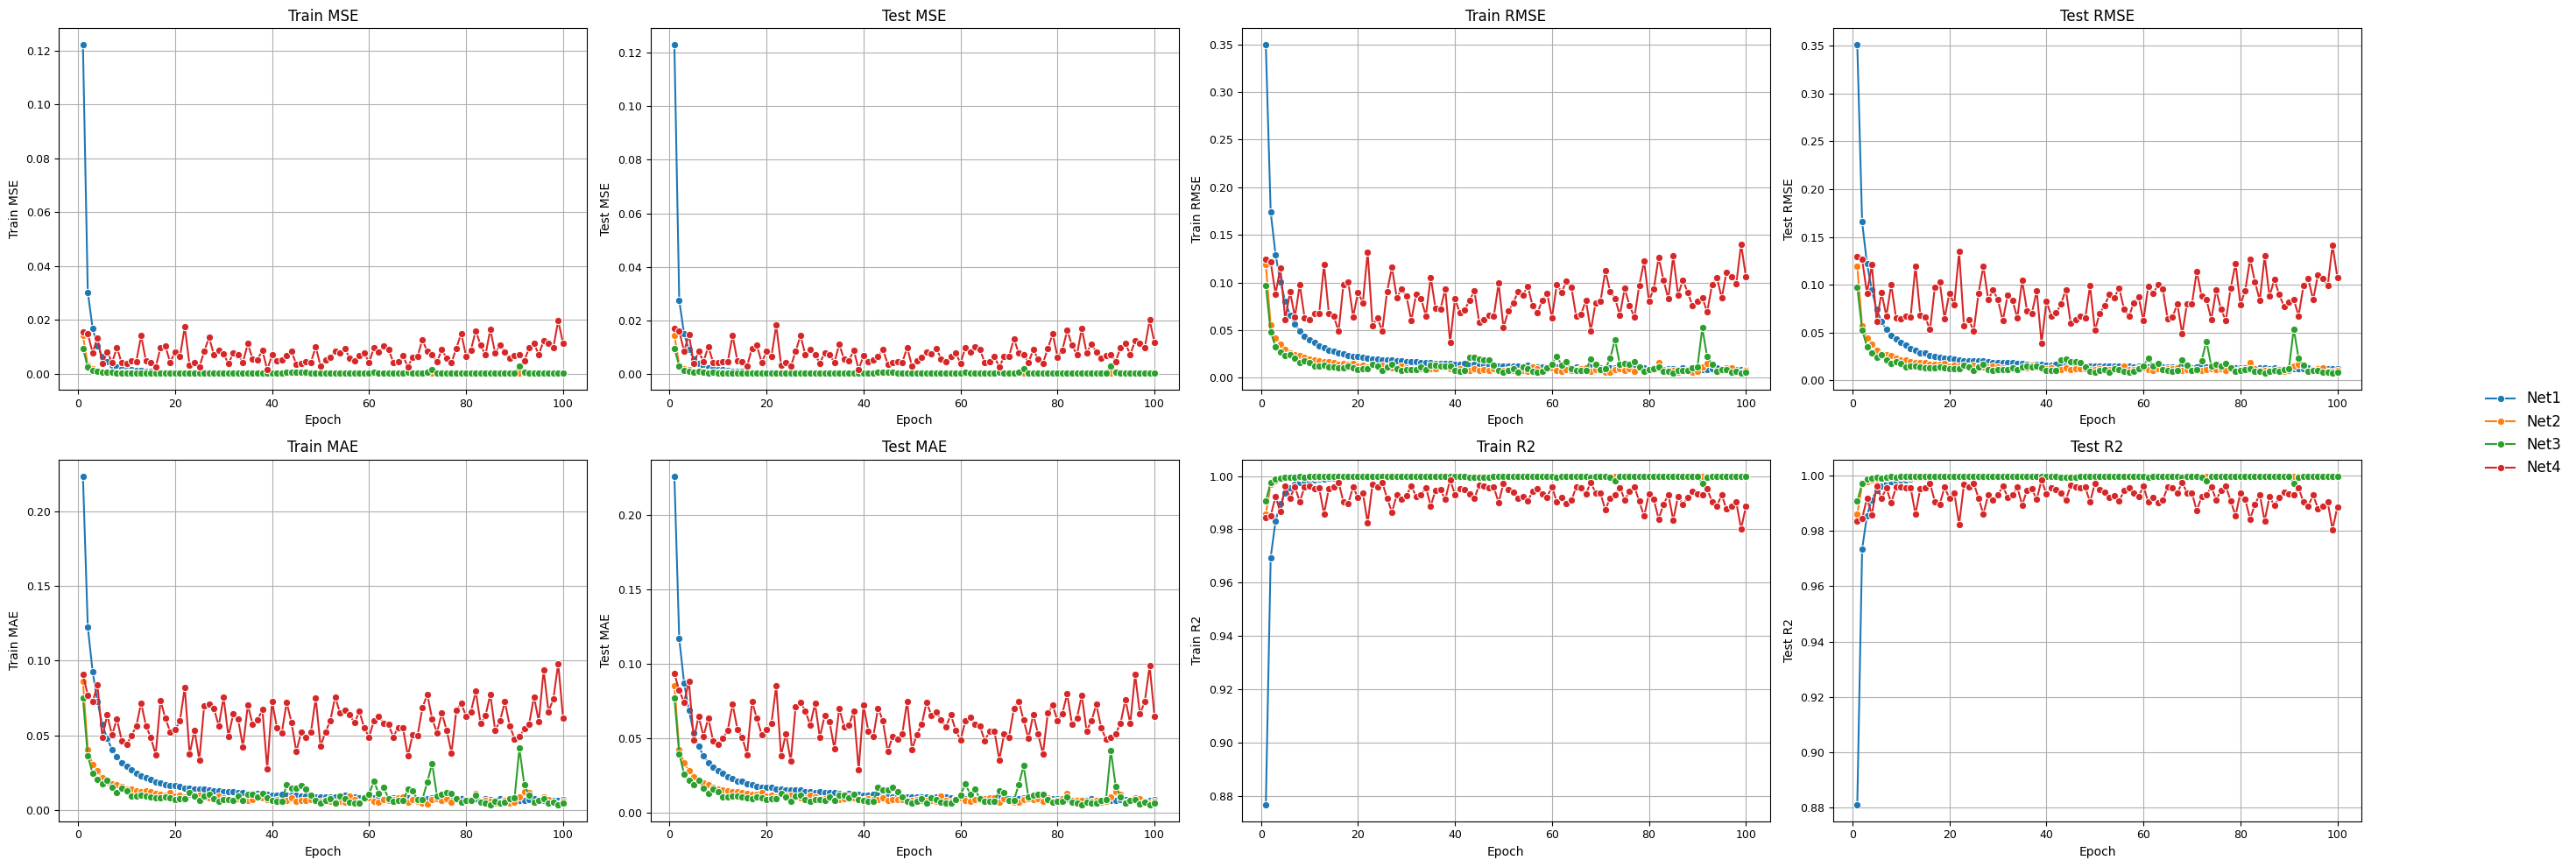

In [22]:
train_figures = {}

metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

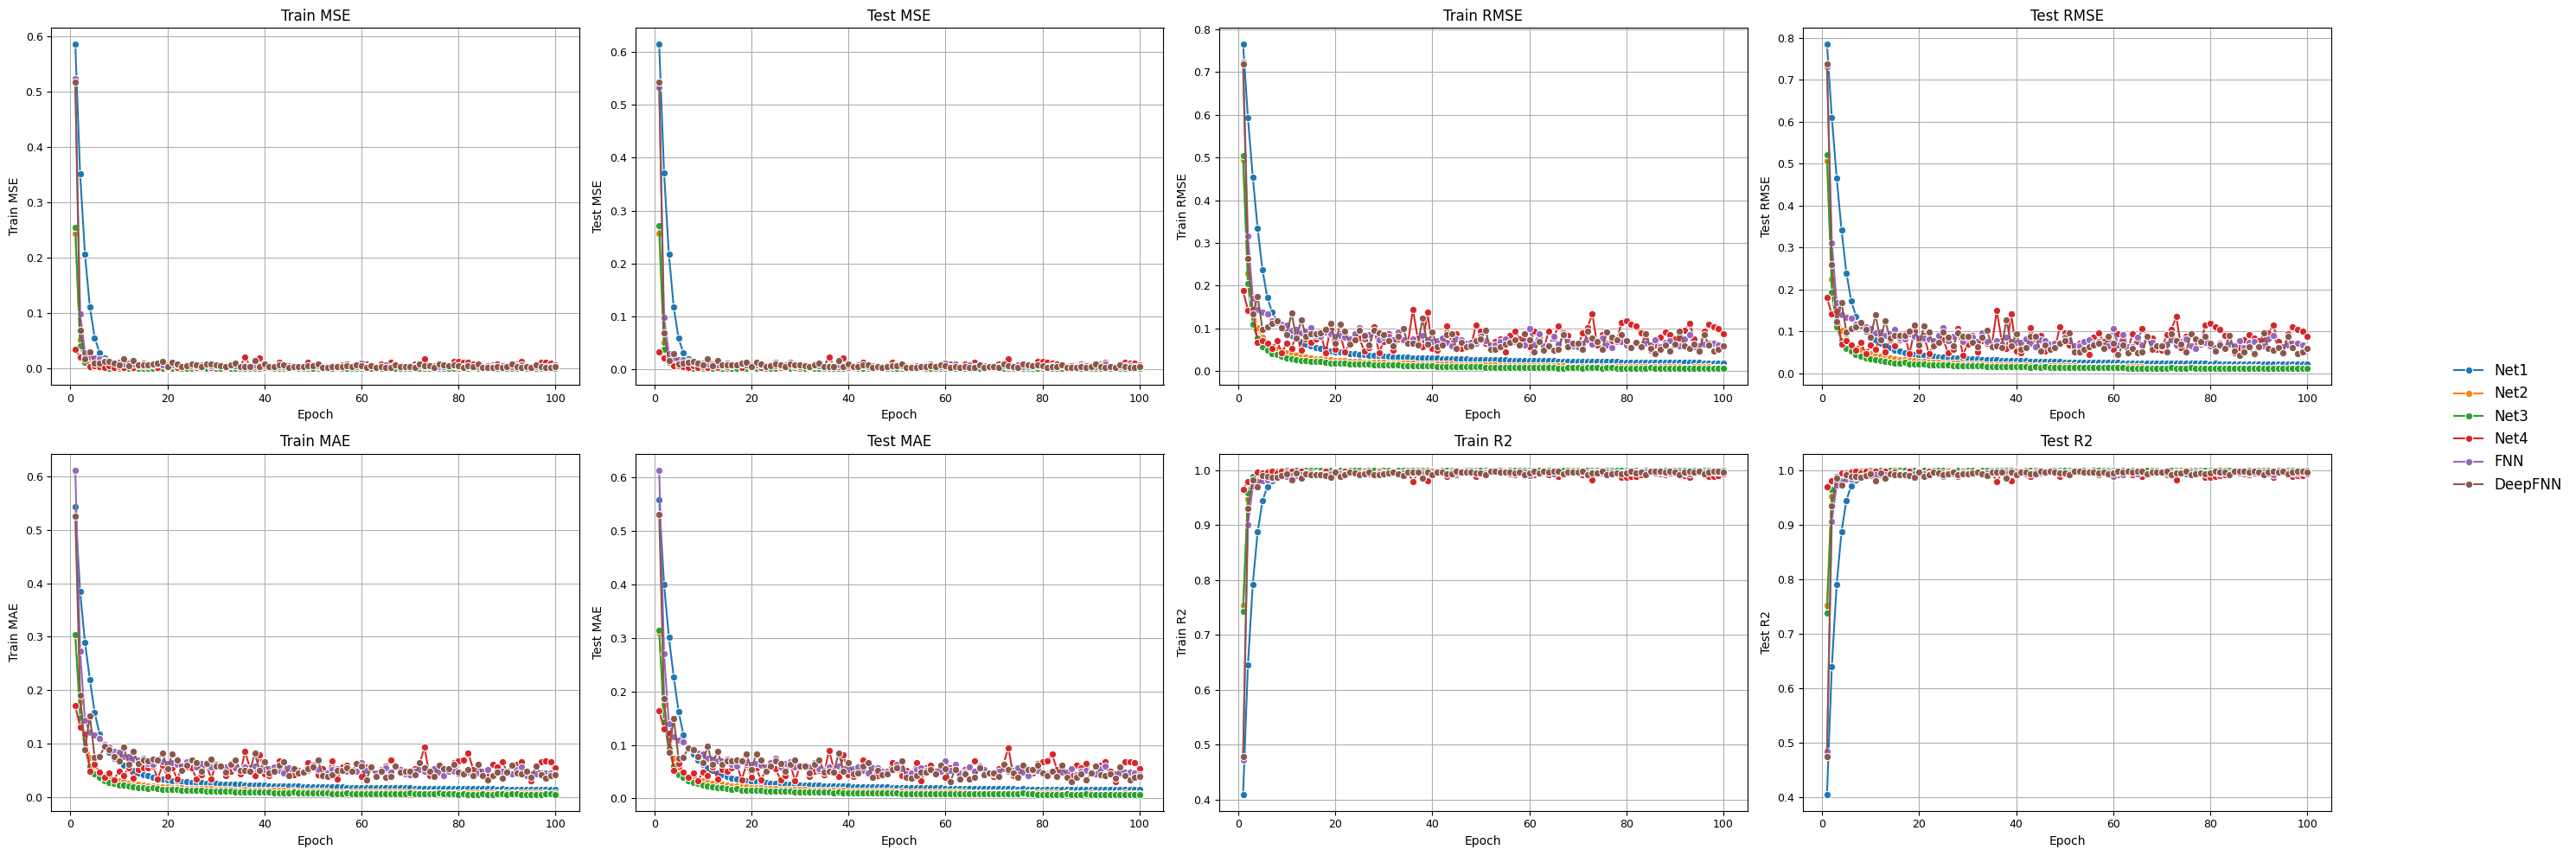

In [23]:
train_figures_tabular = {}

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_tabular["Train_Metrics_Tabular"] = fig

plt.show()
plt.close()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [25]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [26]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN:   1%|▉                                                                                        | 1/100 [00:02<04:45,  2.88s/it]


Model: TCN | Epoch: 1/100
Train: MSE: 0.0447, RMSE: 0.2113, MAE: 0.1301, R2: 0.9554
Test:  MSE: 0.1625, RMSE: 0.4031, MAE: 0.2962, R2: 0.9337


Training TCN:  10%|████████▊                                                                               | 10/100 [00:33<04:39,  3.10s/it]


Model: TCN | Epoch: 10/100
Train: MSE: 0.0230, RMSE: 0.1517, MAE: 0.0862, R2: 0.9770
Test:  MSE: 0.1932, RMSE: 0.4395, MAE: 0.3336, R2: 0.9212


Training TCN:  20%|█████████████████▌                                                                      | 20/100 [00:59<03:33,  2.67s/it]


Model: TCN | Epoch: 20/100
Train: MSE: 0.0148, RMSE: 0.1217, MAE: 0.0656, R2: 0.9852
Test:  MSE: 0.0720, RMSE: 0.2684, MAE: 0.2124, R2: 0.9706


Training TCN:  30%|██████████████████████████▍                                                             | 30/100 [01:28<03:47,  3.25s/it]


Model: TCN | Epoch: 30/100
Train: MSE: 0.0126, RMSE: 0.1122, MAE: 0.0595, R2: 0.9874
Test:  MSE: 0.0614, RMSE: 0.2479, MAE: 0.1835, R2: 0.9749


Training TCN:  40%|███████████████████████████████████▏                                                    | 40/100 [01:58<03:07,  3.13s/it]


Model: TCN | Epoch: 40/100
Train: MSE: 0.0113, RMSE: 0.1063, MAE: 0.0580, R2: 0.9887
Test:  MSE: 0.0580, RMSE: 0.2409, MAE: 0.1882, R2: 0.9763


Training TCN:  50%|████████████████████████████████████████████                                            | 50/100 [03:01<04:36,  5.53s/it]


Model: TCN | Epoch: 50/100
Train: MSE: 0.0117, RMSE: 0.1081, MAE: 0.0606, R2: 0.9883
Test:  MSE: 0.1075, RMSE: 0.3278, MAE: 0.2233, R2: 0.9562


Training TCN:  60%|████████████████████████████████████████████████████▊                                   | 60/100 [03:41<02:38,  3.96s/it]


Model: TCN | Epoch: 60/100
Train: MSE: 0.0094, RMSE: 0.0968, MAE: 0.0535, R2: 0.9906
Test:  MSE: 0.0475, RMSE: 0.2179, MAE: 0.1679, R2: 0.9806


Training TCN:  70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [04:11<01:27,  2.90s/it]


Model: TCN | Epoch: 70/100
Train: MSE: 0.0139, RMSE: 0.1179, MAE: 0.0670, R2: 0.9861
Test:  MSE: 0.0949, RMSE: 0.3081, MAE: 0.2276, R2: 0.9613


Training TCN:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [04:39<00:56,  2.84s/it]


Model: TCN | Epoch: 80/100
Train: MSE: 0.0078, RMSE: 0.0883, MAE: 0.0469, R2: 0.9922
Test:  MSE: 0.0232, RMSE: 0.1522, MAE: 0.1168, R2: 0.9906


Training TCN:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [05:07<00:28,  2.81s/it]


Model: TCN | Epoch: 90/100
Train: MSE: 0.0066, RMSE: 0.0814, MAE: 0.0485, R2: 0.9934
Test:  MSE: 0.0395, RMSE: 0.1988, MAE: 0.1448, R2: 0.9839


Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:36<00:00,  3.37s/it]



Model: TCN | Epoch: 100/100
Train: MSE: 0.0062, RMSE: 0.0790, MAE: 0.0433, R2: 0.9938
Test:  MSE: 0.0574, RMSE: 0.2395, MAE: 0.1827, R2: 0.9766


Training CNN1D:   1%|▊                                                                                      | 1/100 [00:00<00:39,  2.51it/s]


Model: CNN1D | Epoch: 1/100
Train: MSE: 0.2877, RMSE: 0.5363, MAE: 0.3083, R2: 0.7127
Test:  MSE: 2.0665, RMSE: 1.4375, MAE: 1.3007, R2: 0.1570


Training CNN1D:  10%|████████▌                                                                             | 10/100 [00:03<00:38,  2.35it/s]


Model: CNN1D | Epoch: 10/100
Train: MSE: 0.0316, RMSE: 0.1777, MAE: 0.0953, R2: 0.9685
Test:  MSE: 0.2513, RMSE: 0.5012, MAE: 0.3671, R2: 0.8975


Training CNN1D:  20%|█████████████████▏                                                                    | 20/100 [00:07<00:32,  2.49it/s]


Model: CNN1D | Epoch: 20/100
Train: MSE: 0.0267, RMSE: 0.1634, MAE: 0.0977, R2: 0.9733
Test:  MSE: 0.0906, RMSE: 0.3010, MAE: 0.2167, R2: 0.9630


Training CNN1D:  30%|█████████████████████████▊                                                            | 30/100 [00:11<00:26,  2.64it/s]


Model: CNN1D | Epoch: 30/100
Train: MSE: 0.0209, RMSE: 0.1447, MAE: 0.0795, R2: 0.9791
Test:  MSE: 0.0505, RMSE: 0.2248, MAE: 0.1776, R2: 0.9794


Training CNN1D:  40%|██████████████████████████████████▍                                                   | 40/100 [00:15<00:22,  2.63it/s]


Model: CNN1D | Epoch: 40/100
Train: MSE: 0.0190, RMSE: 0.1378, MAE: 0.0727, R2: 0.9810
Test:  MSE: 0.0387, RMSE: 0.1968, MAE: 0.1345, R2: 0.9842


Training CNN1D:  50%|███████████████████████████████████████████                                           | 50/100 [00:19<00:19,  2.60it/s]


Model: CNN1D | Epoch: 50/100
Train: MSE: 0.0178, RMSE: 0.1335, MAE: 0.0719, R2: 0.9822
Test:  MSE: 0.0384, RMSE: 0.1959, MAE: 0.1566, R2: 0.9843


Training CNN1D:  60%|███████████████████████████████████████████████████▌                                  | 60/100 [00:23<00:15,  2.56it/s]


Model: CNN1D | Epoch: 60/100
Train: MSE: 0.0177, RMSE: 0.1332, MAE: 0.0713, R2: 0.9823
Test:  MSE: 0.0341, RMSE: 0.1846, MAE: 0.1283, R2: 0.9861


Training CNN1D:  70%|████████████████████████████████████████████████████████████▏                         | 70/100 [00:27<00:11,  2.61it/s]


Model: CNN1D | Epoch: 70/100
Train: MSE: 0.0183, RMSE: 0.1352, MAE: 0.0842, R2: 0.9818
Test:  MSE: 0.0353, RMSE: 0.1880, MAE: 0.1371, R2: 0.9856


Training CNN1D:  80%|████████████████████████████████████████████████████████████████████▊                 | 80/100 [00:31<00:07,  2.58it/s]


Model: CNN1D | Epoch: 80/100
Train: MSE: 0.0156, RMSE: 0.1251, MAE: 0.0682, R2: 0.9844
Test:  MSE: 0.0374, RMSE: 0.1934, MAE: 0.1464, R2: 0.9847


Training CNN1D:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 90/100 [00:34<00:03,  2.57it/s]


Model: CNN1D | Epoch: 90/100
Train: MSE: 0.0157, RMSE: 0.1254, MAE: 0.0744, R2: 0.9843
Test:  MSE: 0.0344, RMSE: 0.1856, MAE: 0.1311, R2: 0.9860


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]



Model: CNN1D | Epoch: 100/100
Train: MSE: 0.0137, RMSE: 0.1171, MAE: 0.0593, R2: 0.9863
Test:  MSE: 0.0256, RMSE: 0.1600, MAE: 0.1165, R2: 0.9896


Training GRUNet:   1%|▊                                                                                     | 1/100 [00:00<00:24,  4.05it/s]


Model: GRUNet | Epoch: 1/100
Train: MSE: 0.2435, RMSE: 0.4935, MAE: 0.2748, R2: 0.7568
Test:  MSE: 1.7020, RMSE: 1.3046, MAE: 1.2057, R2: 0.3057


Training GRUNet:  10%|████████▌                                                                            | 10/100 [00:02<00:23,  3.85it/s]


Model: GRUNet | Epoch: 10/100
Train: MSE: 0.0276, RMSE: 0.1661, MAE: 0.0845, R2: 0.9724
Test:  MSE: 0.1958, RMSE: 0.4425, MAE: 0.2807, R2: 0.9201


Training GRUNet:  20%|█████████████████                                                                    | 20/100 [00:05<00:21,  3.74it/s]


Model: GRUNet | Epoch: 20/100
Train: MSE: 0.0199, RMSE: 0.1410, MAE: 0.0748, R2: 0.9802
Test:  MSE: 0.3578, RMSE: 0.5982, MAE: 0.3910, R2: 0.8540


Training GRUNet:  30%|█████████████████████████▌                                                           | 30/100 [00:08<00:18,  3.75it/s]


Model: GRUNet | Epoch: 30/100
Train: MSE: 0.0139, RMSE: 0.1181, MAE: 0.0618, R2: 0.9861
Test:  MSE: 0.3022, RMSE: 0.5497, MAE: 0.3569, R2: 0.8767


Training GRUNet:  40%|██████████████████████████████████                                                   | 40/100 [00:10<00:16,  3.65it/s]


Model: GRUNet | Epoch: 40/100
Train: MSE: 0.0120, RMSE: 0.1094, MAE: 0.0600, R2: 0.9880
Test:  MSE: 0.2969, RMSE: 0.5449, MAE: 0.3590, R2: 0.8789


Training GRUNet:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:13<00:13,  3.62it/s]


Model: GRUNet | Epoch: 50/100
Train: MSE: 0.0121, RMSE: 0.1098, MAE: 0.0555, R2: 0.9880
Test:  MSE: 0.2502, RMSE: 0.5002, MAE: 0.2970, R2: 0.8979


Training GRUNet:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:16<00:11,  3.60it/s]


Model: GRUNet | Epoch: 60/100
Train: MSE: 0.0080, RMSE: 0.0896, MAE: 0.0466, R2: 0.9920
Test:  MSE: 0.3870, RMSE: 0.6221, MAE: 0.3643, R2: 0.8421


Training GRUNet:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:19<00:08,  3.72it/s]


Model: GRUNet | Epoch: 70/100
Train: MSE: 0.0070, RMSE: 0.0838, MAE: 0.0444, R2: 0.9930
Test:  MSE: 0.4581, RMSE: 0.6768, MAE: 0.3928, R2: 0.8131


Training GRUNet:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:21<00:05,  3.69it/s]


Model: GRUNet | Epoch: 80/100
Train: MSE: 0.0059, RMSE: 0.0770, MAE: 0.0408, R2: 0.9941
Test:  MSE: 0.6284, RMSE: 0.7927, MAE: 0.4589, R2: 0.7437


Training GRUNet:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:24<00:02,  3.58it/s]


Model: GRUNet | Epoch: 90/100
Train: MSE: 0.0050, RMSE: 0.0705, MAE: 0.0419, R2: 0.9950
Test:  MSE: 0.6407, RMSE: 0.8004, MAE: 0.4564, R2: 0.7386


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]



Model: GRUNet | Epoch: 100/100
Train: MSE: 0.0051, RMSE: 0.0712, MAE: 0.0394, R2: 0.9949
Test:  MSE: 0.6376, RMSE: 0.7985, MAE: 0.4546, R2: 0.7399


Training RNNNet:   1%|▊                                                                                     | 1/100 [00:00<00:12,  7.73it/s]


Model: RNNNet | Epoch: 1/100
Train: MSE: 0.0405, RMSE: 0.2013, MAE: 0.1219, R2: 0.9595
Test:  MSE: 0.1016, RMSE: 0.3188, MAE: 0.3032, R2: 0.9585


Training RNNNet:  11%|█████████▎                                                                           | 11/100 [00:01<00:10,  8.15it/s]


Model: RNNNet | Epoch: 10/100
Train: MSE: 0.0213, RMSE: 0.1461, MAE: 0.0951, R2: 0.9787
Test:  MSE: 0.0561, RMSE: 0.2368, MAE: 0.2057, R2: 0.9771


Training RNNNet:  21%|█████████████████▊                                                                   | 21/100 [00:02<00:10,  7.36it/s]


Model: RNNNet | Epoch: 20/100
Train: MSE: 0.0147, RMSE: 0.1214, MAE: 0.0684, R2: 0.9853
Test:  MSE: 0.0734, RMSE: 0.2710, MAE: 0.2151, R2: 0.9701


Training RNNNet:  31%|██████████████████████████▎                                                          | 31/100 [00:04<00:09,  7.41it/s]


Model: RNNNet | Epoch: 30/100
Train: MSE: 0.0132, RMSE: 0.1150, MAE: 0.0651, R2: 0.9868
Test:  MSE: 0.1601, RMSE: 0.4001, MAE: 0.3554, R2: 0.9347


Training RNNNet:  41%|██████████████████████████████████▊                                                  | 41/100 [00:05<00:08,  7.08it/s]


Model: RNNNet | Epoch: 40/100
Train: MSE: 0.0136, RMSE: 0.1166, MAE: 0.0707, R2: 0.9864
Test:  MSE: 0.1597, RMSE: 0.3996, MAE: 0.2911, R2: 0.9349


Training RNNNet:  51%|███████████████████████████████████████████▎                                         | 51/100 [00:06<00:06,  7.64it/s]


Model: RNNNet | Epoch: 50/100
Train: MSE: 0.0111, RMSE: 0.1053, MAE: 0.0643, R2: 0.9889
Test:  MSE: 0.2052, RMSE: 0.4530, MAE: 0.3526, R2: 0.9163


Training RNNNet:  61%|███████████████████████████████████████████████████▊                                 | 61/100 [00:08<00:05,  7.45it/s]


Model: RNNNet | Epoch: 60/100
Train: MSE: 0.0089, RMSE: 0.0941, MAE: 0.0501, R2: 0.9911
Test:  MSE: 0.1993, RMSE: 0.4465, MAE: 0.3615, R2: 0.9187


Training RNNNet:  71%|████████████████████████████████████████████████████████████▎                        | 71/100 [00:09<00:04,  7.06it/s]


Model: RNNNet | Epoch: 70/100
Train: MSE: 0.0087, RMSE: 0.0931, MAE: 0.0539, R2: 0.9913
Test:  MSE: 0.1463, RMSE: 0.3825, MAE: 0.2707, R2: 0.9403


Training RNNNet:  81%|████████████████████████████████████████████████████████████████████▊                | 81/100 [00:11<00:02,  7.38it/s]


Model: RNNNet | Epoch: 80/100
Train: MSE: 0.0082, RMSE: 0.0908, MAE: 0.0536, R2: 0.9918
Test:  MSE: 0.2353, RMSE: 0.4851, MAE: 0.3779, R2: 0.9040


Training RNNNet:  91%|█████████████████████████████████████████████████████████████████████████████▎       | 91/100 [00:12<00:01,  7.40it/s]


Model: RNNNet | Epoch: 90/100
Train: MSE: 0.0081, RMSE: 0.0898, MAE: 0.0592, R2: 0.9920
Test:  MSE: 0.1957, RMSE: 0.4424, MAE: 0.3491, R2: 0.9202


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]



Model: RNNNet | Epoch: 100/100
Train: MSE: 0.0055, RMSE: 0.0739, MAE: 0.0417, R2: 0.9945
Test:  MSE: 0.1665, RMSE: 0.4081, MAE: 0.3094, R2: 0.9321


Training CNNLSTM:   1%|▊                                                                                    | 1/100 [00:04<07:24,  4.49s/it]


Model: CNNLSTM | Epoch: 1/100
Train: MSE: 0.4293, RMSE: 0.6552, MAE: 0.3864, R2: 0.5713
Test:  MSE: 3.0373, RMSE: 1.7428, MAE: 1.6501, R2: -0.2390


Training CNNLSTM:  10%|████████▍                                                                           | 10/100 [00:44<06:35,  4.39s/it]


Model: CNNLSTM | Epoch: 10/100
Train: MSE: 0.0458, RMSE: 0.2140, MAE: 0.1168, R2: 0.9543
Test:  MSE: 0.0411, RMSE: 0.2027, MAE: 0.1558, R2: 0.9832


Training CNNLSTM:  20%|████████████████▊                                                                   | 20/100 [01:34<06:55,  5.20s/it]


Model: CNNLSTM | Epoch: 20/100
Train: MSE: 0.0330, RMSE: 0.1817, MAE: 0.0983, R2: 0.9670
Test:  MSE: 0.0384, RMSE: 0.1959, MAE: 0.1566, R2: 0.9843


Training CNNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [02:36<07:21,  6.30s/it]


Model: CNNLSTM | Epoch: 30/100
Train: MSE: 0.0305, RMSE: 0.1745, MAE: 0.0947, R2: 0.9696
Test:  MSE: 0.0576, RMSE: 0.2401, MAE: 0.1871, R2: 0.9765


Training CNNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [03:35<05:47,  5.79s/it]


Model: CNNLSTM | Epoch: 40/100
Train: MSE: 0.0335, RMSE: 0.1830, MAE: 0.1070, R2: 0.9666
Test:  MSE: 0.0614, RMSE: 0.2478, MAE: 0.1806, R2: 0.9749


Training CNNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [04:35<04:53,  5.87s/it]


Model: CNNLSTM | Epoch: 50/100
Train: MSE: 0.0230, RMSE: 0.1517, MAE: 0.0835, R2: 0.9770
Test:  MSE: 0.0478, RMSE: 0.2187, MAE: 0.1719, R2: 0.9805


Training CNNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [05:33<03:52,  5.81s/it]


Model: CNNLSTM | Epoch: 60/100
Train: MSE: 0.0228, RMSE: 0.1510, MAE: 0.0870, R2: 0.9772
Test:  MSE: 0.0422, RMSE: 0.2054, MAE: 0.1601, R2: 0.9828


Training CNNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [06:31<02:56,  5.89s/it]


Model: CNNLSTM | Epoch: 70/100
Train: MSE: 0.0189, RMSE: 0.1375, MAE: 0.0731, R2: 0.9811
Test:  MSE: 0.0387, RMSE: 0.1968, MAE: 0.1517, R2: 0.9842


Training CNNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [07:32<02:01,  6.05s/it]


Model: CNNLSTM | Epoch: 80/100
Train: MSE: 0.0181, RMSE: 0.1346, MAE: 0.0743, R2: 0.9819
Test:  MSE: 0.0283, RMSE: 0.1682, MAE: 0.1356, R2: 0.9885


Training CNNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [08:33<01:02,  6.26s/it]


Model: CNNLSTM | Epoch: 90/100
Train: MSE: 0.0157, RMSE: 0.1254, MAE: 0.0681, R2: 0.9843
Test:  MSE: 0.0426, RMSE: 0.2064, MAE: 0.1553, R2: 0.9826


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [09:45<00:00,  5.86s/it]



Model: CNNLSTM | Epoch: 100/100
Train: MSE: 0.0159, RMSE: 0.1263, MAE: 0.0738, R2: 0.9841
Test:  MSE: 0.0604, RMSE: 0.2457, MAE: 0.2014, R2: 0.9754


Training BiLSTMNet:   1%|▊                                                                                  | 1/100 [00:00<01:27,  1.13it/s]


Model: BiLSTMNet | Epoch: 1/100
Train: MSE: 0.2657, RMSE: 0.5154, MAE: 0.2752, R2: 0.7347
Test:  MSE: 2.0616, RMSE: 1.4358, MAE: 1.2337, R2: 0.1590


Training BiLSTMNet:  10%|████████▏                                                                         | 10/100 [00:09<01:25,  1.05it/s]


Model: BiLSTMNet | Epoch: 10/100
Train: MSE: 0.0299, RMSE: 0.1730, MAE: 0.0909, R2: 0.9701
Test:  MSE: 0.3225, RMSE: 0.5679, MAE: 0.3384, R2: 0.8685


Training BiLSTMNet:  20%|████████████████▍                                                                 | 20/100 [00:18<01:08,  1.17it/s]


Model: BiLSTMNet | Epoch: 20/100
Train: MSE: 0.0206, RMSE: 0.1435, MAE: 0.0736, R2: 0.9794
Test:  MSE: 0.2157, RMSE: 0.4644, MAE: 0.2869, R2: 0.9120


Training BiLSTMNet:  30%|████████████████████████▌                                                         | 30/100 [00:27<01:11,  1.02s/it]


Model: BiLSTMNet | Epoch: 30/100
Train: MSE: 0.0180, RMSE: 0.1341, MAE: 0.0712, R2: 0.9820
Test:  MSE: 0.1466, RMSE: 0.3829, MAE: 0.2786, R2: 0.9402


Training BiLSTMNet:  40%|████████████████████████████████▊                                                 | 40/100 [00:36<00:49,  1.22it/s]


Model: BiLSTMNet | Epoch: 40/100
Train: MSE: 0.0146, RMSE: 0.1210, MAE: 0.0624, R2: 0.9854
Test:  MSE: 0.1246, RMSE: 0.3529, MAE: 0.2473, R2: 0.9492


Training BiLSTMNet:  50%|█████████████████████████████████████████                                         | 50/100 [00:45<00:46,  1.08it/s]


Model: BiLSTMNet | Epoch: 50/100
Train: MSE: 0.0132, RMSE: 0.1148, MAE: 0.0648, R2: 0.9868
Test:  MSE: 0.1251, RMSE: 0.3537, MAE: 0.2363, R2: 0.9490


Training BiLSTMNet:  60%|█████████████████████████████████████████████████▏                                | 60/100 [00:54<00:35,  1.12it/s]


Model: BiLSTMNet | Epoch: 60/100
Train: MSE: 0.0189, RMSE: 0.1373, MAE: 0.0791, R2: 0.9812
Test:  MSE: 0.0751, RMSE: 0.2740, MAE: 0.1775, R2: 0.9694


Training BiLSTMNet:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:03<00:28,  1.05it/s]


Model: BiLSTMNet | Epoch: 70/100
Train: MSE: 0.0131, RMSE: 0.1143, MAE: 0.0705, R2: 0.9869
Test:  MSE: 0.0581, RMSE: 0.2410, MAE: 0.1601, R2: 0.9763


Training BiLSTMNet:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:14<00:24,  1.20s/it]


Model: BiLSTMNet | Epoch: 80/100
Train: MSE: 0.0109, RMSE: 0.1044, MAE: 0.0605, R2: 0.9891
Test:  MSE: 0.1088, RMSE: 0.3299, MAE: 0.2191, R2: 0.9556


Training BiLSTMNet:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [01:23<00:09,  1.10it/s]


Model: BiLSTMNet | Epoch: 90/100
Train: MSE: 0.0084, RMSE: 0.0918, MAE: 0.0514, R2: 0.9916
Test:  MSE: 0.0792, RMSE: 0.2814, MAE: 0.1951, R2: 0.9677


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]



Model: BiLSTMNet | Epoch: 100/100
Train: MSE: 0.0073, RMSE: 0.0857, MAE: 0.0510, R2: 0.9927
Test:  MSE: 0.0796, RMSE: 0.2822, MAE: 0.1943, R2: 0.9675


Training DeepLSTMNet:   1%|▊                                                                                | 1/100 [00:01<03:09,  1.91s/it]


Model: DeepLSTMNet | Epoch: 1/100
Train: MSE: 0.1350, RMSE: 0.3674, MAE: 0.2026, R2: 0.8652
Test:  MSE: 0.1776, RMSE: 0.4215, MAE: 0.2858, R2: 0.9275


Training DeepLSTMNet:  10%|████████                                                                        | 10/100 [00:18<02:45,  1.84s/it]


Model: DeepLSTMNet | Epoch: 10/100
Train: MSE: 0.0339, RMSE: 0.1841, MAE: 0.1021, R2: 0.9662
Test:  MSE: 0.2635, RMSE: 0.5134, MAE: 0.3375, R2: 0.8925


Training DeepLSTMNet:  20%|████████████████                                                                | 20/100 [00:35<02:03,  1.54s/it]


Model: DeepLSTMNet | Epoch: 20/100
Train: MSE: 0.0238, RMSE: 0.1541, MAE: 0.0791, R2: 0.9763
Test:  MSE: 0.1004, RMSE: 0.3169, MAE: 0.1930, R2: 0.9590


Training DeepLSTMNet:  30%|████████████████████████                                                        | 30/100 [00:50<01:43,  1.48s/it]


Model: DeepLSTMNet | Epoch: 30/100
Train: MSE: 0.0241, RMSE: 0.1552, MAE: 0.0841, R2: 0.9759
Test:  MSE: 0.0555, RMSE: 0.2357, MAE: 0.1261, R2: 0.9773


Training DeepLSTMNet:  40%|████████████████████████████████                                                | 40/100 [01:05<01:30,  1.51s/it]


Model: DeepLSTMNet | Epoch: 40/100
Train: MSE: 0.0200, RMSE: 0.1415, MAE: 0.0780, R2: 0.9800
Test:  MSE: 0.0079, RMSE: 0.0889, MAE: 0.0658, R2: 0.9968


Training DeepLSTMNet:  50%|████████████████████████████████████████                                        | 50/100 [01:20<01:16,  1.52s/it]


Model: DeepLSTMNet | Epoch: 50/100
Train: MSE: 0.0236, RMSE: 0.1538, MAE: 0.0755, R2: 0.9764
Test:  MSE: 0.0271, RMSE: 0.1646, MAE: 0.1198, R2: 0.9889


Training DeepLSTMNet:  60%|████████████████████████████████████████████████                                | 60/100 [01:35<01:01,  1.55s/it]


Model: DeepLSTMNet | Epoch: 60/100
Train: MSE: 0.0149, RMSE: 0.1219, MAE: 0.0688, R2: 0.9852
Test:  MSE: 0.0273, RMSE: 0.1652, MAE: 0.1227, R2: 0.9889


Training DeepLSTMNet:  70%|████████████████████████████████████████████████████████                        | 70/100 [01:53<00:53,  1.77s/it]


Model: DeepLSTMNet | Epoch: 70/100
Train: MSE: 0.0153, RMSE: 0.1237, MAE: 0.0677, R2: 0.9847
Test:  MSE: 0.0404, RMSE: 0.2010, MAE: 0.1446, R2: 0.9835


Training DeepLSTMNet:  80%|████████████████████████████████████████████████████████████████                | 80/100 [02:09<00:34,  1.70s/it]


Model: DeepLSTMNet | Epoch: 80/100
Train: MSE: 0.0109, RMSE: 0.1046, MAE: 0.0577, R2: 0.9891
Test:  MSE: 0.0930, RMSE: 0.3049, MAE: 0.2104, R2: 0.9621


Training DeepLSTMNet:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [02:27<00:18,  1.89s/it]


Model: DeepLSTMNet | Epoch: 90/100
Train: MSE: 0.0100, RMSE: 0.1001, MAE: 0.0570, R2: 0.9900
Test:  MSE: 0.1475, RMSE: 0.3840, MAE: 0.2415, R2: 0.9398


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]



Model: DeepLSTMNet | Epoch: 100/100
Train: MSE: 0.0071, RMSE: 0.0843, MAE: 0.0471, R2: 0.9929
Test:  MSE: 0.1536, RMSE: 0.3919, MAE: 0.2264, R2: 0.9374


Training CNNBiLSTM:   1%|▊                                                                                  | 1/100 [00:01<01:57,  1.18s/it]


Model: CNNBiLSTM | Epoch: 1/100
Train: MSE: 0.2123, RMSE: 0.4608, MAE: 0.2683, R2: 0.7880
Test:  MSE: 1.5768, RMSE: 1.2557, MAE: 1.0243, R2: 0.3568


Training CNNBiLSTM:  10%|████████▏                                                                         | 10/100 [00:11<01:44,  1.16s/it]


Model: CNNBiLSTM | Epoch: 10/100
Train: MSE: 0.0236, RMSE: 0.1538, MAE: 0.0799, R2: 0.9764
Test:  MSE: 0.0426, RMSE: 0.2063, MAE: 0.1581, R2: 0.9826


Training CNNBiLSTM:  20%|████████████████▍                                                                 | 20/100 [00:23<01:33,  1.16s/it]


Model: CNNBiLSTM | Epoch: 20/100
Train: MSE: 0.0204, RMSE: 0.1430, MAE: 0.0727, R2: 0.9796
Test:  MSE: 0.0167, RMSE: 0.1291, MAE: 0.1115, R2: 0.9932


Training CNNBiLSTM:  30%|████████████████████████▌                                                         | 30/100 [00:35<01:21,  1.16s/it]


Model: CNNBiLSTM | Epoch: 30/100
Train: MSE: 0.0180, RMSE: 0.1342, MAE: 0.0728, R2: 0.9820
Test:  MSE: 0.0153, RMSE: 0.1236, MAE: 0.1066, R2: 0.9938


Training CNNBiLSTM:  40%|████████████████████████████████▊                                                 | 40/100 [00:47<01:09,  1.16s/it]


Model: CNNBiLSTM | Epoch: 40/100
Train: MSE: 0.0169, RMSE: 0.1299, MAE: 0.0690, R2: 0.9831
Test:  MSE: 0.0333, RMSE: 0.1824, MAE: 0.1575, R2: 0.9864


Training CNNBiLSTM:  50%|█████████████████████████████████████████                                         | 50/100 [00:59<01:00,  1.21s/it]


Model: CNNBiLSTM | Epoch: 50/100
Train: MSE: 0.0160, RMSE: 0.1265, MAE: 0.0683, R2: 0.9840
Test:  MSE: 0.0361, RMSE: 0.1901, MAE: 0.1535, R2: 0.9853


Training CNNBiLSTM:  60%|█████████████████████████████████████████████████▏                                | 60/100 [01:11<00:47,  1.18s/it]


Model: CNNBiLSTM | Epoch: 60/100
Train: MSE: 0.0157, RMSE: 0.1255, MAE: 0.0716, R2: 0.9843
Test:  MSE: 0.0252, RMSE: 0.1587, MAE: 0.1365, R2: 0.9897


Training CNNBiLSTM:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:23<00:37,  1.26s/it]


Model: CNNBiLSTM | Epoch: 70/100
Train: MSE: 0.0117, RMSE: 0.1082, MAE: 0.0566, R2: 0.9883
Test:  MSE: 0.0381, RMSE: 0.1951, MAE: 0.1556, R2: 0.9845


Training CNNBiLSTM:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:35<00:23,  1.16s/it]


Model: CNNBiLSTM | Epoch: 80/100
Train: MSE: 0.0107, RMSE: 0.1034, MAE: 0.0566, R2: 0.9893
Test:  MSE: 0.0343, RMSE: 0.1852, MAE: 0.1477, R2: 0.9860


Training CNNBiLSTM:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [01:47<00:11,  1.12s/it]


Model: CNNBiLSTM | Epoch: 90/100
Train: MSE: 0.0133, RMSE: 0.1152, MAE: 0.0663, R2: 0.9868
Test:  MSE: 0.0606, RMSE: 0.2462, MAE: 0.1902, R2: 0.9753


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]



Model: CNNBiLSTM | Epoch: 100/100
Train: MSE: 0.0098, RMSE: 0.0990, MAE: 0.0534, R2: 0.9902
Test:  MSE: 0.0452, RMSE: 0.2126, MAE: 0.1653, R2: 0.9816


Training GRUCNN:   1%|▊                                                                                     | 1/100 [00:00<00:53,  1.85it/s]


Model: GRUCNN | Epoch: 1/100
Train: MSE: 0.2471, RMSE: 0.4970, MAE: 0.2602, R2: 0.7533
Test:  MSE: 1.7890, RMSE: 1.3375, MAE: 1.1844, R2: 0.2702


Training GRUCNN:  10%|████████▌                                                                            | 10/100 [00:05<00:47,  1.89it/s]


Model: GRUCNN | Epoch: 10/100
Train: MSE: 0.0324, RMSE: 0.1799, MAE: 0.0964, R2: 0.9677
Test:  MSE: 0.3122, RMSE: 0.5588, MAE: 0.3727, R2: 0.8726


Training GRUCNN:  20%|█████████████████                                                                    | 20/100 [00:10<00:43,  1.86it/s]


Model: GRUCNN | Epoch: 20/100
Train: MSE: 0.0265, RMSE: 0.1629, MAE: 0.0825, R2: 0.9735
Test:  MSE: 0.2143, RMSE: 0.4629, MAE: 0.3199, R2: 0.9126


Training GRUCNN:  30%|█████████████████████████▌                                                           | 30/100 [00:15<00:36,  1.93it/s]


Model: GRUCNN | Epoch: 30/100
Train: MSE: 0.0236, RMSE: 0.1537, MAE: 0.0783, R2: 0.9764
Test:  MSE: 0.1094, RMSE: 0.3307, MAE: 0.2279, R2: 0.9554


Training GRUCNN:  40%|██████████████████████████████████                                                   | 40/100 [00:21<00:31,  1.89it/s]


Model: GRUCNN | Epoch: 40/100
Train: MSE: 0.0233, RMSE: 0.1528, MAE: 0.0799, R2: 0.9767
Test:  MSE: 0.1023, RMSE: 0.3198, MAE: 0.1994, R2: 0.9583


Training GRUCNN:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:26<00:26,  1.87it/s]


Model: GRUCNN | Epoch: 50/100
Train: MSE: 0.0181, RMSE: 0.1346, MAE: 0.0725, R2: 0.9819
Test:  MSE: 0.0759, RMSE: 0.2755, MAE: 0.1885, R2: 0.9690


Training GRUCNN:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:31<00:20,  1.93it/s]


Model: GRUCNN | Epoch: 60/100
Train: MSE: 0.0193, RMSE: 0.1390, MAE: 0.0795, R2: 0.9807
Test:  MSE: 0.1137, RMSE: 0.3372, MAE: 0.2386, R2: 0.9536


Training GRUCNN:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:37<00:16,  1.84it/s]


Model: GRUCNN | Epoch: 70/100
Train: MSE: 0.0126, RMSE: 0.1122, MAE: 0.0561, R2: 0.9874
Test:  MSE: 0.0878, RMSE: 0.2964, MAE: 0.1887, R2: 0.9642


Training GRUCNN:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:42<00:10,  1.91it/s]


Model: GRUCNN | Epoch: 80/100
Train: MSE: 0.0112, RMSE: 0.1057, MAE: 0.0529, R2: 0.9888
Test:  MSE: 0.0777, RMSE: 0.2788, MAE: 0.1756, R2: 0.9683


Training GRUCNN:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:47<00:05,  1.88it/s]


Model: GRUCNN | Epoch: 90/100
Train: MSE: 0.0102, RMSE: 0.1011, MAE: 0.0539, R2: 0.9898
Test:  MSE: 0.1104, RMSE: 0.3323, MAE: 0.2144, R2: 0.9550


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]



Model: GRUCNN | Epoch: 100/100
Train: MSE: 0.0109, RMSE: 0.1045, MAE: 0.0583, R2: 0.9891
Test:  MSE: 0.0958, RMSE: 0.3094, MAE: 0.1937, R2: 0.9609


Training TCNLSTM:   1%|▊                                                                                    | 1/100 [00:05<08:20,  5.05s/it]


Model: TCNLSTM | Epoch: 1/100
Train: MSE: 0.0513, RMSE: 0.2265, MAE: 0.1420, R2: 0.9488
Test:  MSE: 0.0551, RMSE: 0.2347, MAE: 0.2084, R2: 0.9775


Training TCNLSTM:  10%|████████▍                                                                           | 10/100 [00:46<06:49,  4.55s/it]


Model: TCNLSTM | Epoch: 10/100
Train: MSE: 0.0186, RMSE: 0.1364, MAE: 0.0779, R2: 0.9814
Test:  MSE: 0.0406, RMSE: 0.2016, MAE: 0.1443, R2: 0.9834


Training TCNLSTM:  20%|████████████████▊                                                                   | 20/100 [01:32<06:05,  4.56s/it]


Model: TCNLSTM | Epoch: 20/100
Train: MSE: 0.0129, RMSE: 0.1134, MAE: 0.0608, R2: 0.9872
Test:  MSE: 0.0231, RMSE: 0.1521, MAE: 0.1222, R2: 0.9906


Training TCNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [02:16<05:03,  4.33s/it]


Model: TCNLSTM | Epoch: 30/100
Train: MSE: 0.0109, RMSE: 0.1043, MAE: 0.0584, R2: 0.9891
Test:  MSE: 0.0392, RMSE: 0.1980, MAE: 0.1508, R2: 0.9840


Training TCNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [02:58<04:08,  4.15s/it]


Model: TCNLSTM | Epoch: 40/100
Train: MSE: 0.0095, RMSE: 0.0976, MAE: 0.0560, R2: 0.9905
Test:  MSE: 0.0469, RMSE: 0.2166, MAE: 0.1731, R2: 0.9809


Training TCNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [03:41<03:30,  4.21s/it]


Model: TCNLSTM | Epoch: 50/100
Train: MSE: 0.0079, RMSE: 0.0890, MAE: 0.0486, R2: 0.9921
Test:  MSE: 0.0382, RMSE: 0.1955, MAE: 0.1530, R2: 0.9844


Training TCNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [04:23<02:48,  4.21s/it]


Model: TCNLSTM | Epoch: 60/100
Train: MSE: 0.0079, RMSE: 0.0891, MAE: 0.0499, R2: 0.9921
Test:  MSE: 0.0495, RMSE: 0.2224, MAE: 0.1673, R2: 0.9798


Training TCNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [05:05<02:05,  4.19s/it]


Model: TCNLSTM | Epoch: 70/100
Train: MSE: 0.0056, RMSE: 0.0747, MAE: 0.0419, R2: 0.9944
Test:  MSE: 0.0487, RMSE: 0.2206, MAE: 0.1720, R2: 0.9801


Training TCNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [05:47<01:23,  4.19s/it]


Model: TCNLSTM | Epoch: 80/100
Train: MSE: 0.0051, RMSE: 0.0718, MAE: 0.0424, R2: 0.9949
Test:  MSE: 0.0387, RMSE: 0.1967, MAE: 0.1598, R2: 0.9842


Training TCNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [06:30<00:41,  4.20s/it]


Model: TCNLSTM | Epoch: 90/100
Train: MSE: 0.0044, RMSE: 0.0660, MAE: 0.0384, R2: 0.9957
Test:  MSE: 0.0477, RMSE: 0.2183, MAE: 0.1730, R2: 0.9806


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [07:12<00:00,  4.33s/it]



Model: TCNLSTM | Epoch: 100/100
Train: MSE: 0.0042, RMSE: 0.0647, MAE: 0.0384, R2: 0.9958
Test:  MSE: 0.0480, RMSE: 0.2192, MAE: 0.1750, R2: 0.9804


Training Seq2SeqLSTM:   1%|▊                                                                                | 1/100 [00:00<00:49,  1.99it/s]


Model: Seq2SeqLSTM | Epoch: 1/100
Train: MSE: 0.2779, RMSE: 0.5272, MAE: 0.2777, R2: 0.7225
Test:  MSE: 2.0401, RMSE: 1.4283, MAE: 1.2196, R2: 0.1678


Training Seq2SeqLSTM:  10%|████████                                                                        | 10/100 [00:05<00:49,  1.82it/s]


Model: Seq2SeqLSTM | Epoch: 10/100
Train: MSE: 0.0306, RMSE: 0.1750, MAE: 0.0907, R2: 0.9694
Test:  MSE: 0.4050, RMSE: 0.6364, MAE: 0.4176, R2: 0.8348


Training Seq2SeqLSTM:  20%|████████████████                                                                | 20/100 [00:10<00:40,  1.96it/s]


Model: Seq2SeqLSTM | Epoch: 20/100
Train: MSE: 0.0250, RMSE: 0.1580, MAE: 0.0798, R2: 0.9751
Test:  MSE: 0.2054, RMSE: 0.4532, MAE: 0.2749, R2: 0.9162


Training Seq2SeqLSTM:  30%|████████████████████████                                                        | 30/100 [00:15<00:37,  1.86it/s]


Model: Seq2SeqLSTM | Epoch: 30/100
Train: MSE: 0.0193, RMSE: 0.1390, MAE: 0.0736, R2: 0.9807
Test:  MSE: 0.1718, RMSE: 0.4145, MAE: 0.2573, R2: 0.9299


Training Seq2SeqLSTM:  40%|████████████████████████████████                                                | 40/100 [00:20<00:33,  1.82it/s]


Model: Seq2SeqLSTM | Epoch: 40/100
Train: MSE: 0.0140, RMSE: 0.1182, MAE: 0.0644, R2: 0.9861
Test:  MSE: 0.1450, RMSE: 0.3807, MAE: 0.2490, R2: 0.9409


Training Seq2SeqLSTM:  50%|████████████████████████████████████████                                        | 50/100 [00:26<00:27,  1.81it/s]


Model: Seq2SeqLSTM | Epoch: 50/100
Train: MSE: 0.0111, RMSE: 0.1053, MAE: 0.0580, R2: 0.9889
Test:  MSE: 0.1162, RMSE: 0.3409, MAE: 0.2123, R2: 0.9526


Training Seq2SeqLSTM:  60%|████████████████████████████████████████████████                                | 60/100 [00:31<00:20,  1.95it/s]


Model: Seq2SeqLSTM | Epoch: 60/100
Train: MSE: 0.0089, RMSE: 0.0942, MAE: 0.0519, R2: 0.9911
Test:  MSE: 0.1647, RMSE: 0.4058, MAE: 0.2364, R2: 0.9328


Training Seq2SeqLSTM:  70%|████████████████████████████████████████████████████████                        | 70/100 [00:36<00:15,  1.98it/s]


Model: Seq2SeqLSTM | Epoch: 70/100
Train: MSE: 0.0094, RMSE: 0.0972, MAE: 0.0528, R2: 0.9906
Test:  MSE: 0.1469, RMSE: 0.3833, MAE: 0.2265, R2: 0.9401


Training Seq2SeqLSTM:  80%|████████████████████████████████████████████████████████████████                | 80/100 [00:42<00:11,  1.70it/s]


Model: Seq2SeqLSTM | Epoch: 80/100
Train: MSE: 0.0070, RMSE: 0.0839, MAE: 0.0489, R2: 0.9930
Test:  MSE: 0.1647, RMSE: 0.4059, MAE: 0.2518, R2: 0.9328


Training Seq2SeqLSTM:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [00:48<00:05,  1.82it/s]


Model: Seq2SeqLSTM | Epoch: 90/100
Train: MSE: 0.0068, RMSE: 0.0827, MAE: 0.0491, R2: 0.9932
Test:  MSE: 0.2343, RMSE: 0.4841, MAE: 0.2933, R2: 0.9044


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Model: Seq2SeqLSTM | Epoch: 100/100
Train: MSE: 0.0051, RMSE: 0.0712, MAE: 0.0426, R2: 0.9949
Test:  MSE: 0.1945, RMSE: 0.4410, MAE: 0.2779, R2: 0.9207


In [27]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     91   0.012270  0.049042    0.110769   0.221454   0.066079   
1         CNN1D     87   0.015669  0.018372    0.125176   0.135544   0.063819   
2     CNNBiLSTM     15   0.026682  0.014091    0.163346   0.118705   0.086756   
3       CNNLSTM     85   0.019264  0.021855    0.138796   0.147833   0.078530   
4   DeepLSTMNet     40   0.020026  0.007896    0.141514   0.088861   0.077991   
5        GRUCNN     67   0.017044  0.030721    0.130551   0.175275   0.069022   
6        GRUNet     12   0.033392  0.149007    0.182735   0.386015   0.103057   
7        RNNNet      7   0.019741  0.045126    0.140501   0.212428   0.081657   
8   Seq2SeqLSTM     41   0.015734  0.087939    0.125434   0.296546   0.069251   
9           TCN     92   0.007729  0.014761    0.087915   0.121495   0.051286   
10      TCNLSTM     11   0.017551  0.013311    0.132479   0.115372   0.075785   

    Test MAE  Train R2   Test R2  
0   0.162234  0.987746  0.979995  
1   0.105655  0.984352  0.992505  
2   0.095764  0.973354  0.994252  
3   0.112103  0.980761  0.991085  
4   0.065766  0.980000  0.996779  
5   0.124705  0.982979  0.987468  
6   0.268126  0.966652  0.939216  
7   0.186783  0.980286  0.981592  
8   0.189782  0.984287  0.964127  
9   0.092531  0.992281  0.993979  
10  0.087818  0.982473  0.994570

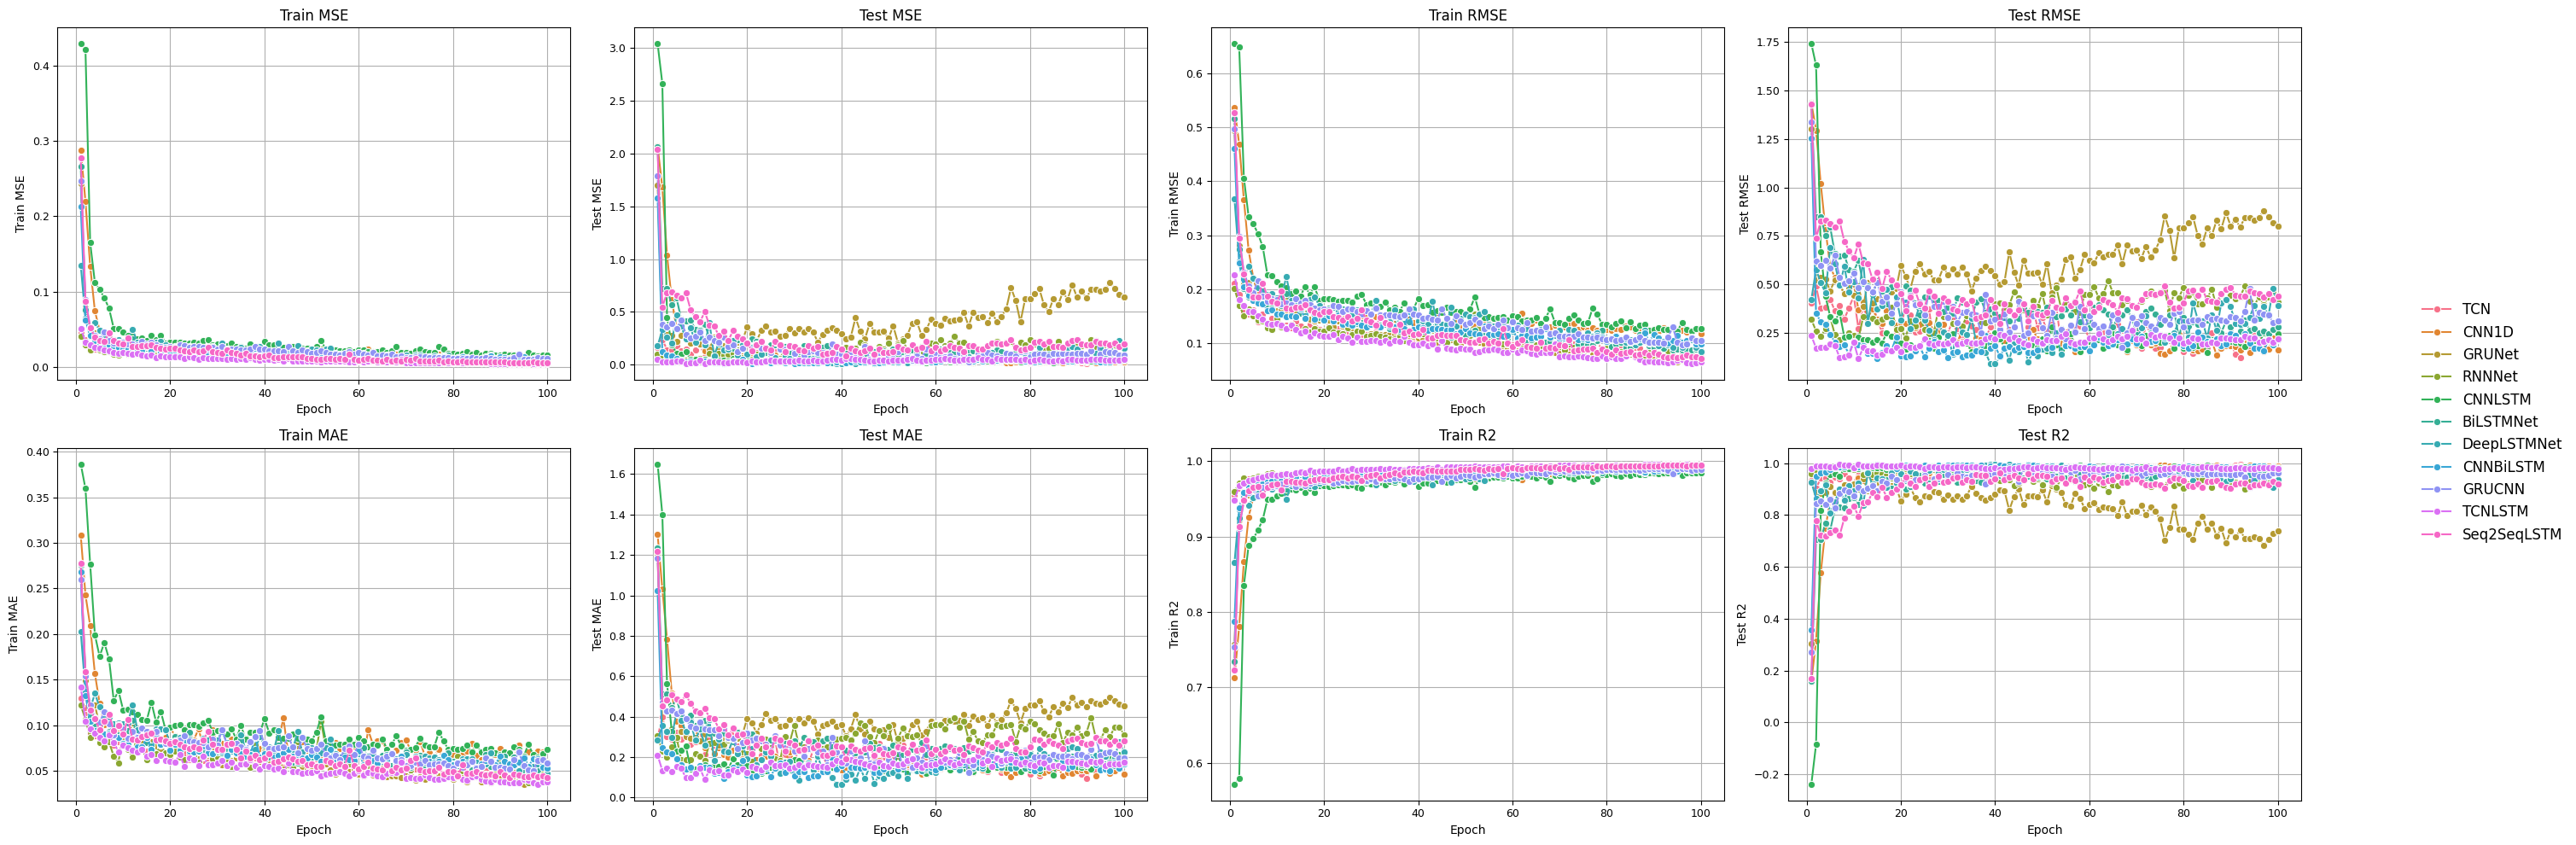

In [29]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", 
          "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]

df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)
    
plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

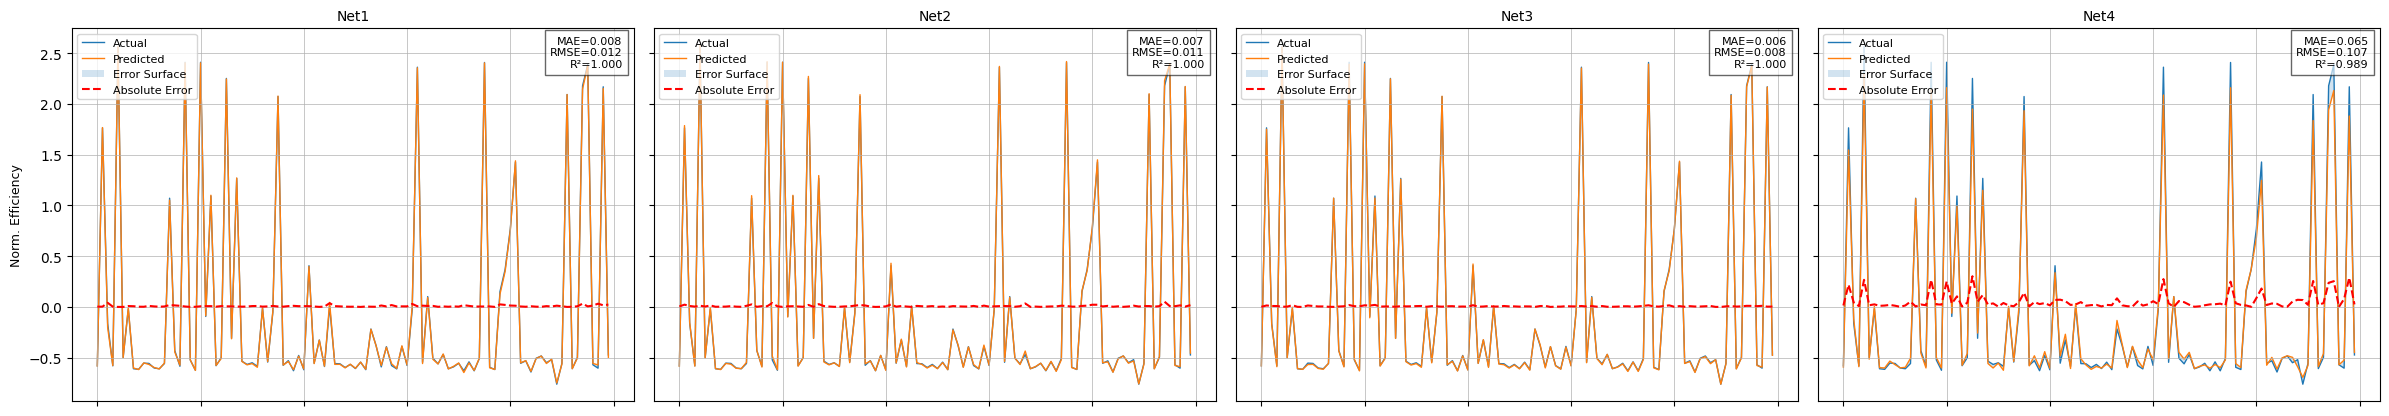

In [30]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 100   
max_pts = 100

last_row_start = nrows * ncols - ncols
offset = (ncols - n_models % ncols) // 2 if n_models % ncols != 0 else 0

for i, (name, model) in enumerate(nets.items()):
    row = i // ncols
    col = i % ncols
    if row == nrows - 1 and n_models % ncols != 0:
        col += offset
    ax_index = row * ncols + col
    ax = axes[ax_index]

    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = (nn_metrics_df.query("Model == @name").sort_values("Epoch").iloc[-1])
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if col == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if row == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()


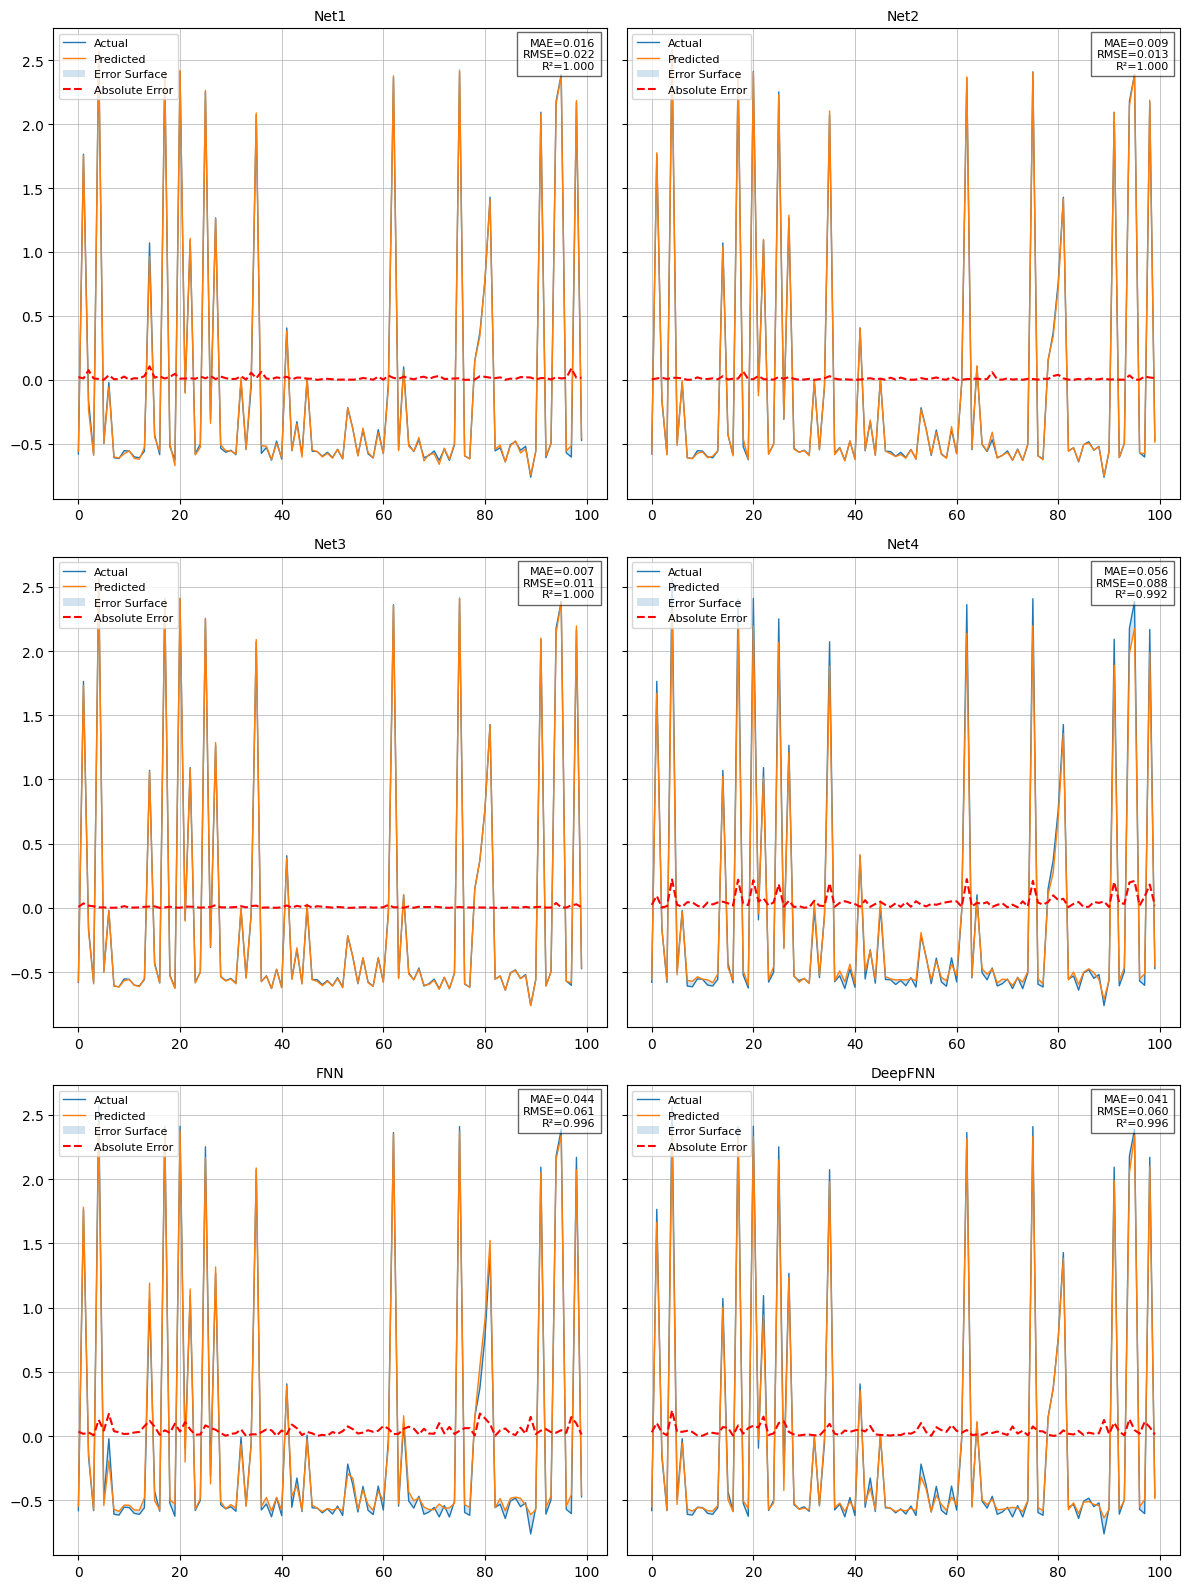

In [31]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
nrows, ncols = 3, 2 

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 16), sharey='row')
axes = axes.flatten()

model_items = list(nets_tabular.items())

for i, (name, model) in enumerate(model_items):
    ax = axes[i]
    model = model.to(device).eval()
    
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

for j in range(len(model_items), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9415/2918183148.py:60: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9415/2918183148.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


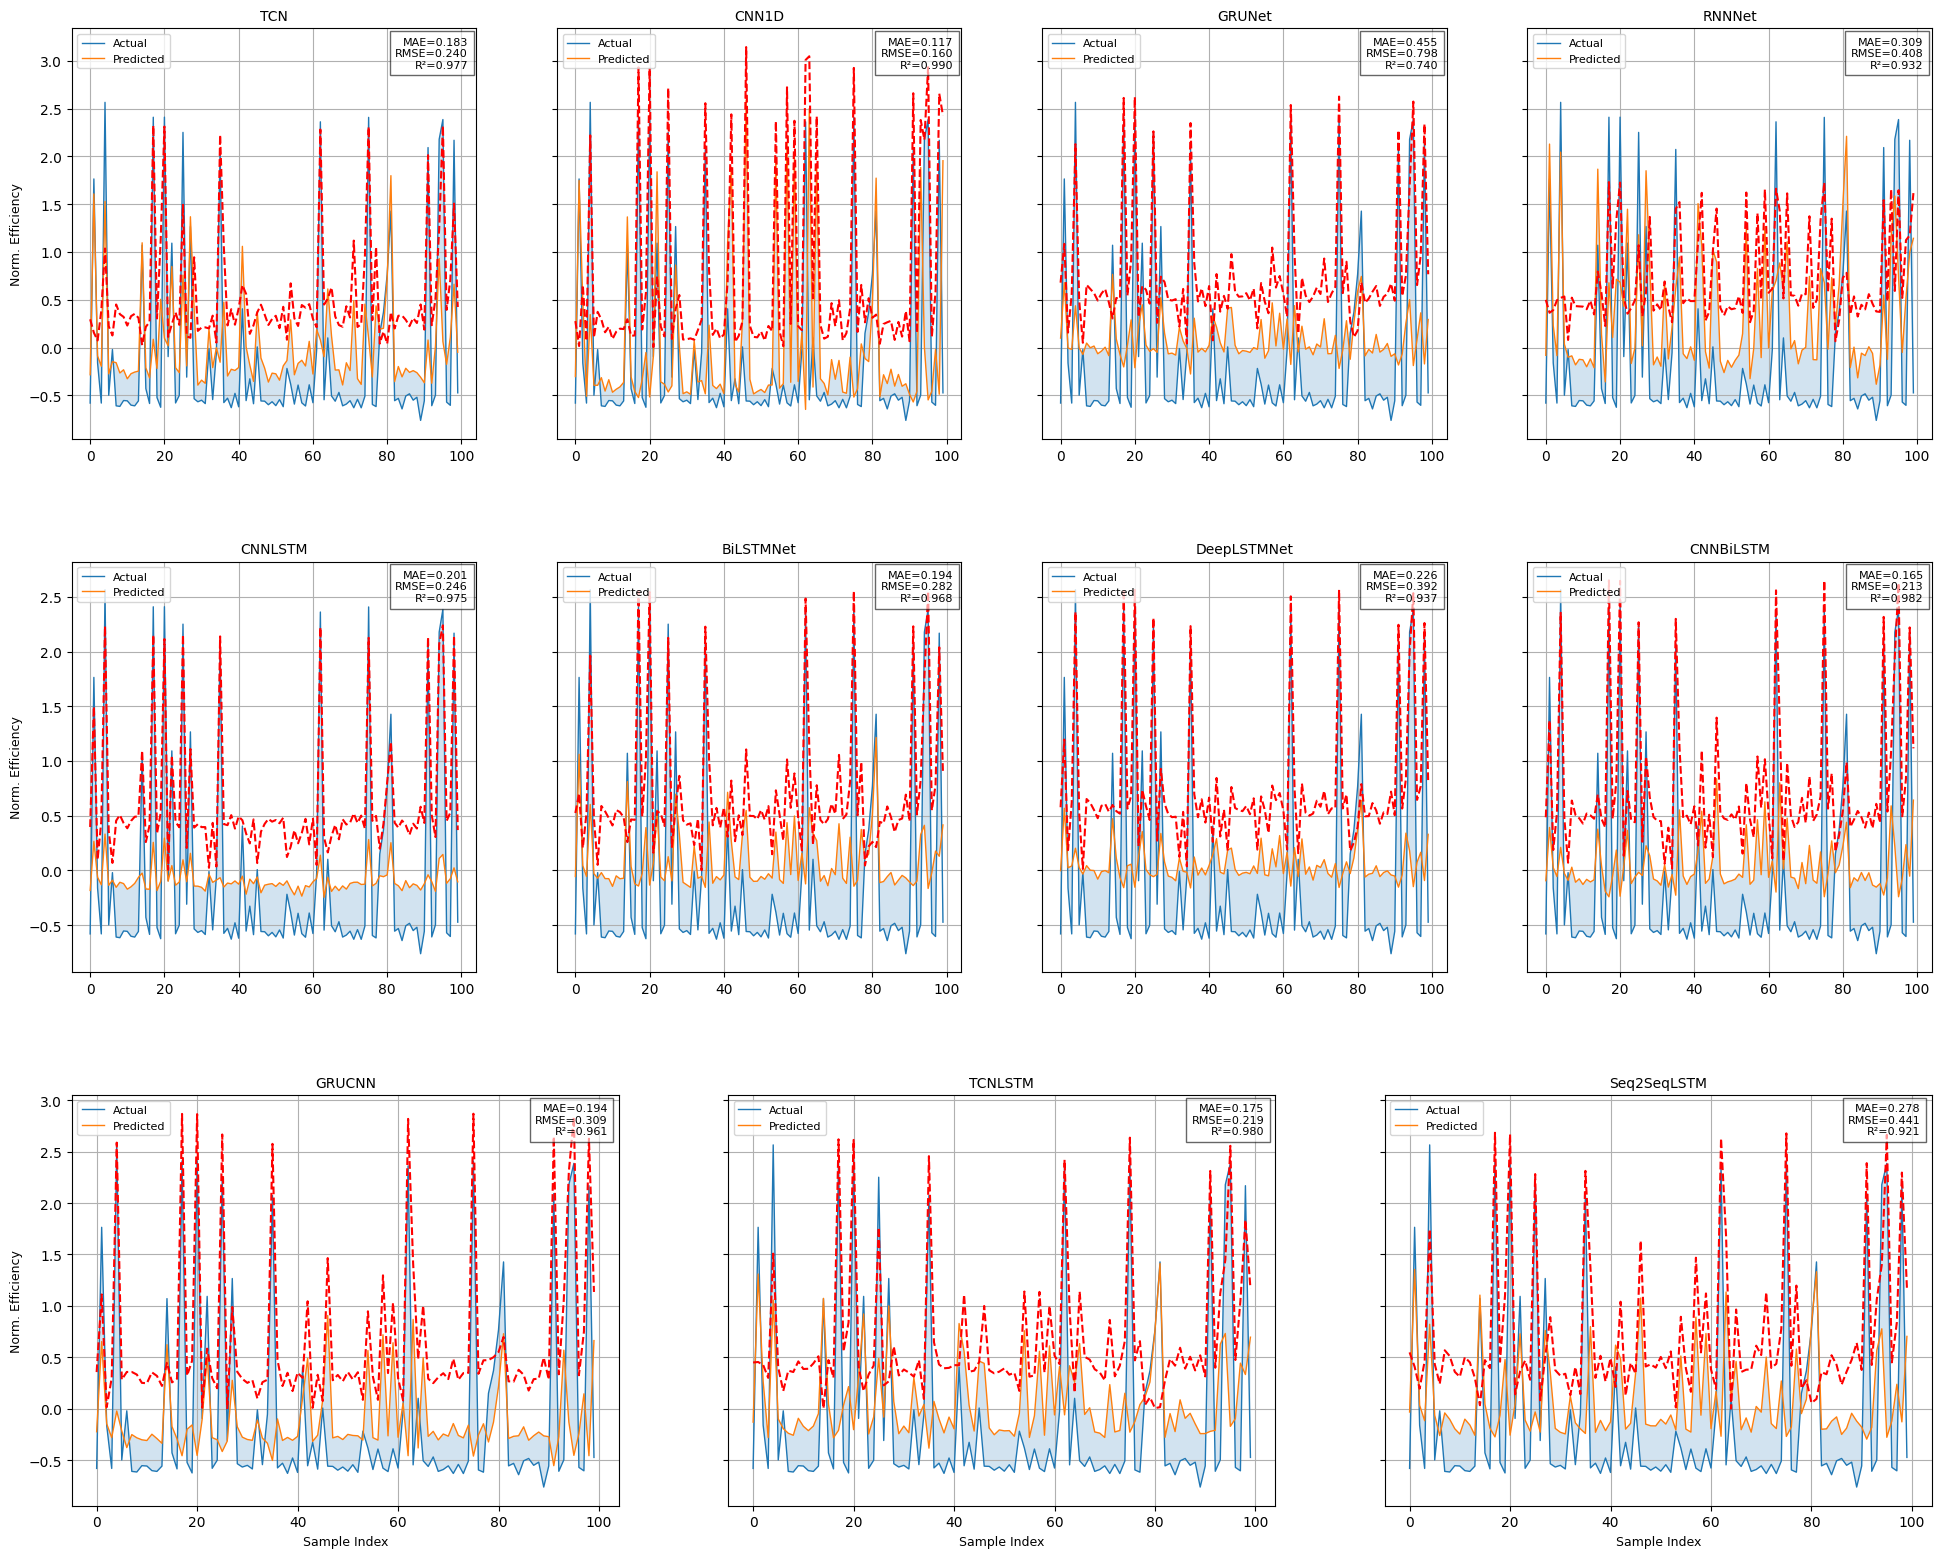

In [51]:
pred_figures_nets_ts = {}
n_models = len(ts_nets)
ncols = 4
full_rows = n_models // ncols   # 2
remainder = n_models % ncols

fig = plt.figure(constrained_layout=True,
                 figsize=(24, 16))
subfigs = fig.subfigures(full_rows + 1, 1,
                         height_ratios=[1]*full_rows + [1])

def plot_model(ax, name, model):
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()
    n = min(100, len(trues))
    idxs = np.linspace(0, n - 1, min(n, 100), dtype=int)
    y_t, y_p = trues[-n:][idxs], preds[-n:][idxs]
    err = np.abs(y_t - y_p)
    ax.plot(idxs, y_t, label="Actual", lw=1)
    ax.plot(idxs, y_p, label="Predicted", lw=1)
    ax.fill_between(idxs, y_t, y_p, alpha=0.2)
    ax.plot(idxs, err, '--', lw=1.5, color='red')
    m = nn_metrics_ts_df.query("Model == @name") \
                        .sort_values("Epoch") \
                        .iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats,
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))
    ax.set_title(name, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8, loc="upper left")
    
for i in range(full_rows):
    axs = subfigs[i].subplots(1, ncols,
                              sharex=True,
                              sharey=True)
    for ax, (name, model) in zip(axs, list(ts_nets.items())[i * ncols:(i + 1) * ncols]):
        plot_model(ax, name, model)
    for ax in axs:
        if axs.tolist().index(ax) == 0:
            ax.set_ylabel("Norm. Efficiency", fontsize=9)
        if i == full_rows: 
            ax.set_xlabel("Sample Index", fontsize=9)

axs_last = subfigs[full_rows].subplots(1, remainder,
                                        sharex=True,
                                        sharey=True)
for ax, (name, model) in zip(axs_last, list(ts_nets.items())[full_rows * ncols :]):
    plot_model(ax, name, model)
    if axs_last.tolist().index(ax) == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    ax.set_xlabel("Sample Index", fontsize=9)

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [52]:
save_ml_experiment(
    station="Amberd1",
    results=results,
    y_test=y_test,
    metrics_df=metrics_df,
    table_fig=table_fig,
    barplot_fig=barplot_fig,
    pred_figs=pred_figs,
    models_dict=models,
    base_dir=Path("..")
)

In [53]:
for name, model in nets.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs=train_figures,
        pred_figs=pred_figures_nets,
        base_dir=Path("..")
    )

In [54]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs=train_figures_tabular,
        pred_figs= pred_figures_nets_tab,
        base_dir=Path("..")
    )

In [55]:
for name, model in ts_nets.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs=train_figures_ts,
        pred_figs=pred_figures_nets_ts,
        base_dir=Path("..")
    )